# 0.0 Imports

In [1]:
import pickle
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import scikitplot as skplt
import matplotlib.patches as mpatches

from tabulate import tabulate
from pycorrcat import pycorrcat
from IPython.display import HTML
from IPython.display import Image
from numerize import numerize as nm
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from credentials.credentialsdb import acess

from xgboost import XGBClassifier
from sklearn import ensemble as en
from sklearn import neighbors as nh
from lightgbm import LGBMClassifier
from imblearn import ensemble as ien
from sklearn import linear_model as lm
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn.metrics import balanced_accuracy_score

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver

f:\SamuelOliveiraAlvesd\Anaconda3\envs\Health_Insurance_Cross_Sell\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    '''Define configurations for jupyter notebook, matplotlib and Pandas.'''
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    display( HTML( '<style>.container{width:100% !important; }</style>'))
#    pd.options.display.max_columns = None
#   pd.options.display.max_rows = None
#    pd.set_option('display.expand_frame_repr', False)
    # configura o pandas para quantidade de casas decimeis
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    warnings.filterwarnings('ignore')
    
    sns.set()


def precision_recall_at_k( data, k=20000 ):
    '''
    Calculate metrics of precision and recall for an total number of rankings (k)
    return tuple of precision and recall, return dataframe with ranking
    '''
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return ((data.loc[k, 'precision_at_k'], data.loc[k, 'recall_at_k']), data)


def gain_lift_curve(yhat, yval, plot = True, axvline='None'):
    '''
    plots gain and lift curve, respectively
    returns the curves and a table used to plot the curves
    '''

    # create table proba with the propensity score for each class (0 and 1)
    table_proba = pd.DataFrame(yhat)

    # add the 'response' column
    table_proba['response'] = yval.values

    # add the 'correct' column to evaluate wheter the prediction was right or not
    x = lambda x: "yes" if x[0] > x[1] and x['response'] == 0 else "yes" if x[1] > x[0] and x['response'] == 1 else "yes" if x[0] == x[1] else "no" 
    table_proba['correct'] = table_proba.apply(x, axis = 1)

    # order by propensity score for the class 1
    table_proba.sort_values(1, ascending = False, inplace = True)

    # create cumulative propensity score
    ## calculate the quantity of class 1 rows
    qty_class_1 = table_proba.groupby('response').count().loc[1,1]

    ## apply a score for every row which response is 1
    x = lambda x: 1/qty_class_1 if x['response'] == 1 else 0
    table_proba['propensity_score'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_propensity_score'] = np.cumsum(table_proba['propensity_score'])

    # create % cumulative of the base
    x = lambda x: 1/len(table_proba)
    table_proba['porc_base'] = table_proba.apply(x, axis = 1)
    table_proba['cumulative_porc_base'] = np.cumsum(table_proba['porc_base'])
    table_proba.drop('porc_base', axis = 1, inplace = True)

    # create the lift column
    table_proba['lift'] = table_proba['cumulative_propensity_score'] / table_proba['cumulative_porc_base']

    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(8, 10))

        # gap between graphics
        fig.tight_layout(pad =5)

        # gain curve
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_propensity_score'], label="cumulative (model)", linewidth = 2.5);
        sns.lineplot(ax = axes[0], x = table_proba['cumulative_porc_base'], y = table_proba['cumulative_porc_base'], label="baseline", linewidth = 2.5, color = 'black' )
        axes[0].lines[1].set_linestyle("--")
        axes[0].legend()
        axes[0].set_title("cumulative gains curve")
        axes[0].set_xlabel("percentage of sample")
        axes[0].set_ylabel("gain")

        if axvline != "None":
            axes[0].axvline(axvline, 0, 1, color='green', ls='--', lw=2)

        # lift curve
        ## do not consider the beginning of the series, as it varies a lot (the sample is still small)
        table_proba_filtered = table_proba.query('cumulative_porc_base >= 0.1')

        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = table_proba_filtered['lift'], label="model", linewidth = 2.5 );
        sns.lineplot(ax = axes[1], x = table_proba_filtered['cumulative_porc_base'], y = np.ones(len(table_proba_filtered)), label="baseline", linewidth = 2.5, color = 'black' )
        axes[1].lines[1].set_linestyle("--")
        axes[1].legend()
        axes[1].set_title("lift curve")
        axes[1].set_xlabel("percentage of sample")

        if axvline != "None":
            axes[1].axvline(axvline, 0, 1, color='green', ls='--', lw=2)
        
        plt.show();
        
    return (table_proba)


def runCrossValidation(model, x_train, x_val_ml, y_train, y_val, n_splits, n_repeats, top_k = 20000, verbose=False):
    '''
    Make cross validation with parameters of total ranking (k)
    return a dataframe with metrics of precision and recall at k
    '''
    # local import
    from sklearn.model_selection import RepeatedStratifiedKFold

    
    if verbose:
        # the lenght_msg is to print only once a specific message
        length_msg = True
        i = 1
    
    # the seed usage provides repeatability 
    np.random.seed(1231234)
    
    # it is necessary to join the train and validation datasets
    x = pd.concat([x_train, x_val_ml])
    y = pd.concat([y_train, y_val])
    
    
    # definition of the cross-validation strategy
    # - the "n_splits" parameter is the number of folds (k)
    # - the "n_repeats" parameter is the number of times cross-validator needs to 
    #   be repeated
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats )
    
    precision_at_k = []
    recall_at_k = []
    
    for train_index, prim_val_index in cv.split(x, y):      
        x_training, x_prim_val = x.iloc[train_index], x.iloc[prim_val_index]
        y_training, y_prim_val = y.iloc[train_index], y.iloc[prim_val_index]
        
        if (verbose == True) and (length_msg == True):
            print(f'training_lenght:{x_training.shape[0]}\nvalidation_lenght:{x_prim_val.shape[0]}\n\n')
            length_msg = False
        
        if verbose:
            print(f'Iteration number:{i}')
            i += 1

        # fit and predict_proba
        model.fit(x_training, y_training)
        yhat_proba = model.predict_proba(x_prim_val)
        
        # get results
        table = gain_lift_curve(yhat_proba,y_prim_val, plot = False)
        metrics, new_table = precision_recall_at_k(table, top_k)
        
        if verbose:
            print(metrics)
            print('')
        
        # save the metrics value to the list
        precision_at_k.append(metrics[0])
        recall_at_k.append(metrics[1])
        
    df_results = pd.DataFrame([[np.mean(precision_at_k),np.std(precision_at_k)], 
                       [np.mean(recall_at_k), np.std(recall_at_k)]],
                      columns = ["mean", "std"])
    
    df_results.index = ["precision_at_k","recall_at_k"]
    
    return(df_results)

In [3]:
jupyter_settings()

## 0.2 Load Data

In [4]:
# Credentials
host = acess.get('host')
port = acess.get('port')
database = acess.get('database')
username = acess.get('username')
password = acess.get('password')

# acess database
conn = pg.connect(user=username,
                  password = password,
                  host = host,
                  port = port,
                  database = database)

# make a cursor into database
cursor = conn.cursor()

# verify all schemas
query_schema = """
    SELECT nspname
    FROM pg_catalog.pg_namespace
    """

cursor.execute(query_schema)
record = cursor.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',),
 ('pg_temp_4',),
 ('pg_toast_temp_4',),
 ('pa005',),
 ('pg_temp_9',),
 ('pg_toast_temp_9',)]

In [5]:
# Verify tables from the schema
#query_tables = """
#    SELECT tablename
#    FROM pg_tables
#    WHERE schemaname='pa004'
#    """

#cursor.execute(query_tables)
#record = cursor.fetchall()
#record

In [6]:
# Collect tables into dataframe
query_tables_insurance = """
    SELECT *
    FROM pa004.users u INNER JOIN pa004.vehicle v ON (u.id = v.id)
                       INNER JOIN pa004.insurance i ON (u.id = i.id)
    """

df_raw = pd.read_sql(query_tables_insurance, conn)

# close connection into database
cursor.close()
conn.close()

# 1.0 Descrição dos dados

In [7]:
df1 = df_raw.copy()

In [8]:
# drop duplicates id columns
df1 = df1.loc[:, ~df1.columns.duplicated()].copy()
df1.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.000,152.000,1,< 1 Year,Yes,0,23367.000,249,0
1,13,Female,41,15.000,14.000,1,1-2 Year,No,1,31409.000,221,0
2,18,Female,25,35.000,152.000,1,< 1 Year,No,1,46622.000,299,0
3,31,Female,26,8.000,160.000,1,< 1 Year,No,0,2630.000,136,0
4,39,Male,45,8.000,124.000,1,1-2 Year,Yes,0,42297.000,264,0


## 1.2 Data Dimension

In [9]:
print(f'Number os rows: {df1.shape[0]}')
print(f'Number os cols: {df1.shape[1]}')

Number os rows: 381109
Number os cols: 12


## 1.3 Data Types

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.7 Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.7.1 Numerical Attributes

In [13]:
# Central tendency and Dispersion
d1 = pd.DataFrame (num_attributes.apply( lambda x: x.max() - x.min() )).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concatenate
m2 = pd.concat([d1, d2]).T.reset_index()
m2.columns = ['attibutes', 'range', 'min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis']
m2 = m2[['attibutes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]

m2

,attibutes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.000,381109.000,381108.000,190555.000,190555.000,110016.836,-0.000,-1.200
1,age,20.000,85.000,65.000,38.823,36.000,15.512,0.673,-0.566
2,region_code,0.000,52.000,52.000,26.389,28.000,13.230,-0.115,-0.868
3,policy_sales_channel,1.000,163.000,162.000,112.034,133.000,54.204,-0.900,-0.971
4,driving_license,0.000,1.000,1.000,0.998,1.000,0.046,-21.595,464.354
5,previously_insured,0.000,1.000,1.000,0.458,0.000,0.498,0.168,-1.972
6,annual_premium,2630.000,540165.000,537535.000,30564.390,31669.000,17213.155,1.766,34.005
7,vintage,10.000,299.000,289.000,154.347,154.000,83.671,0.003,-1.201
8,response,0.000,1.000,1.000,0.123,0.000,0.328,2.302,3.299


### 1.7.2 Categorical Attributes

In [14]:
cat_attributes.apply( lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

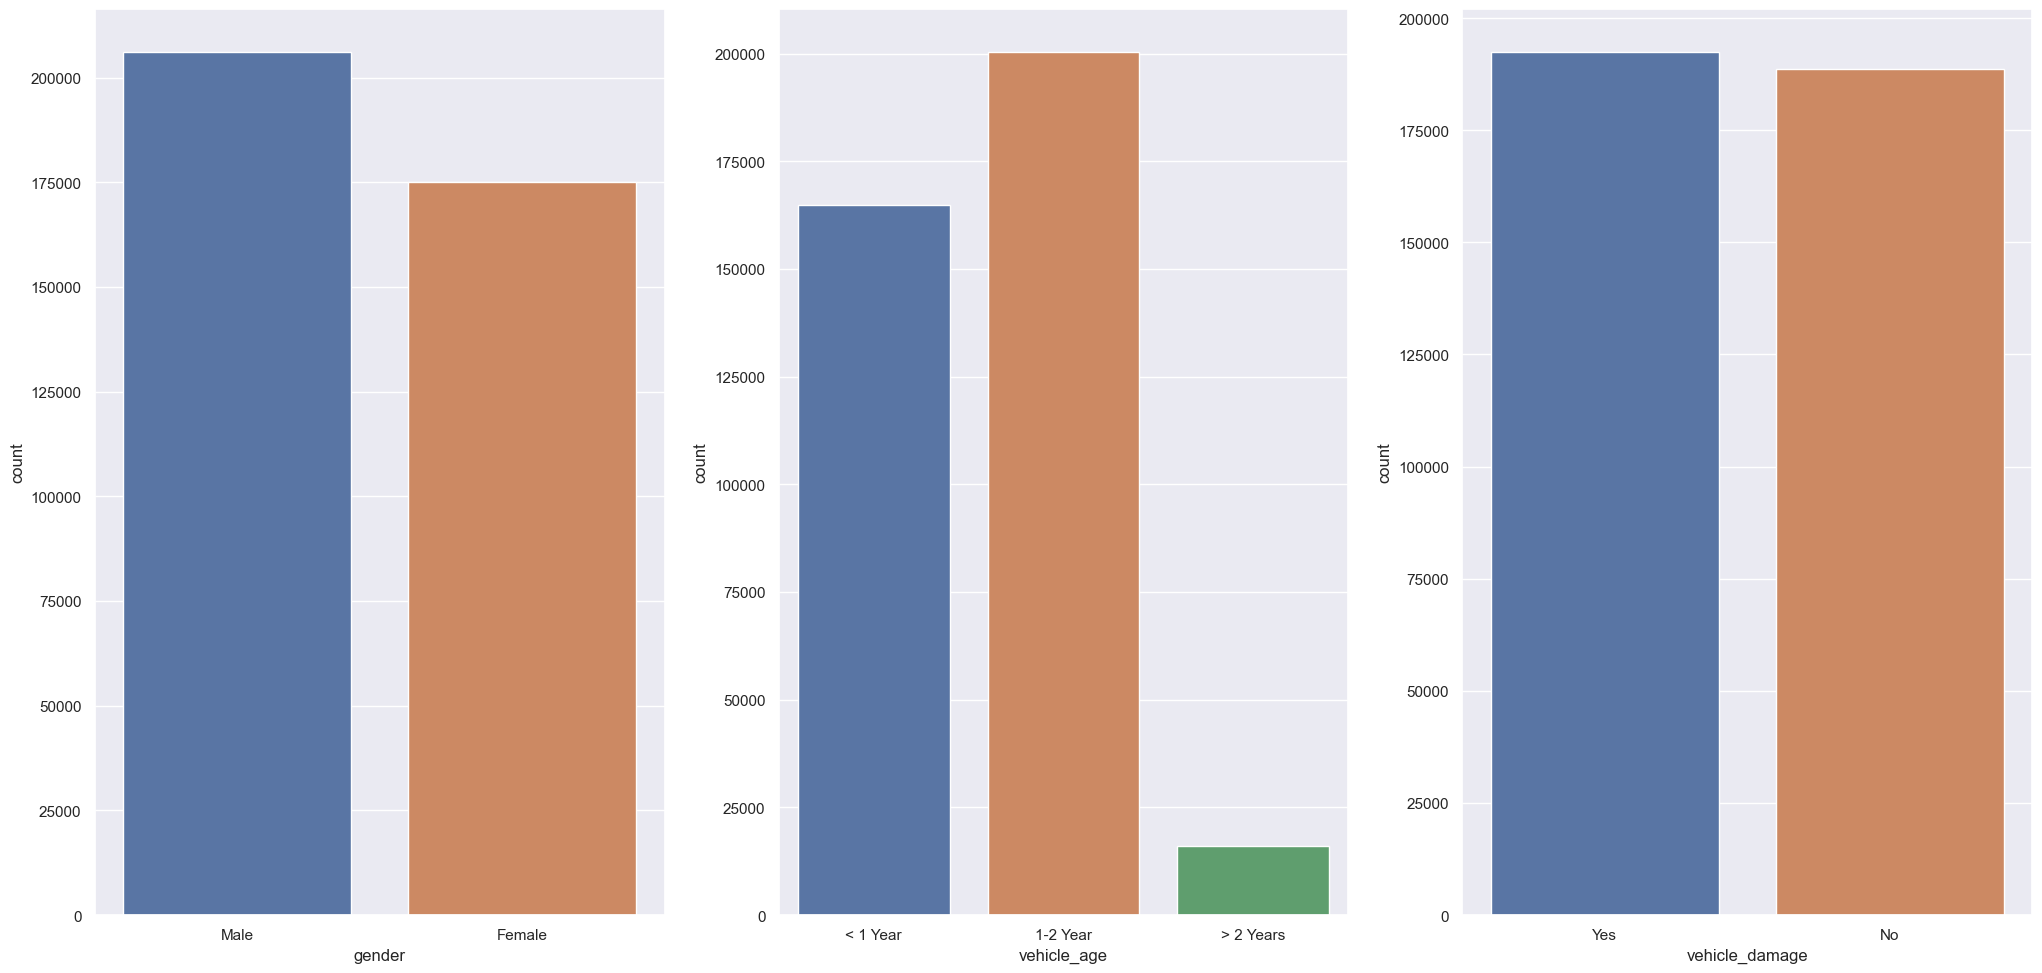

In [15]:
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df1)

plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df1)

plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df1);

# 2.0 Feature Engineering

In [16]:
df2 = df1.copy()

## 2.1 MindMap Hypothesis

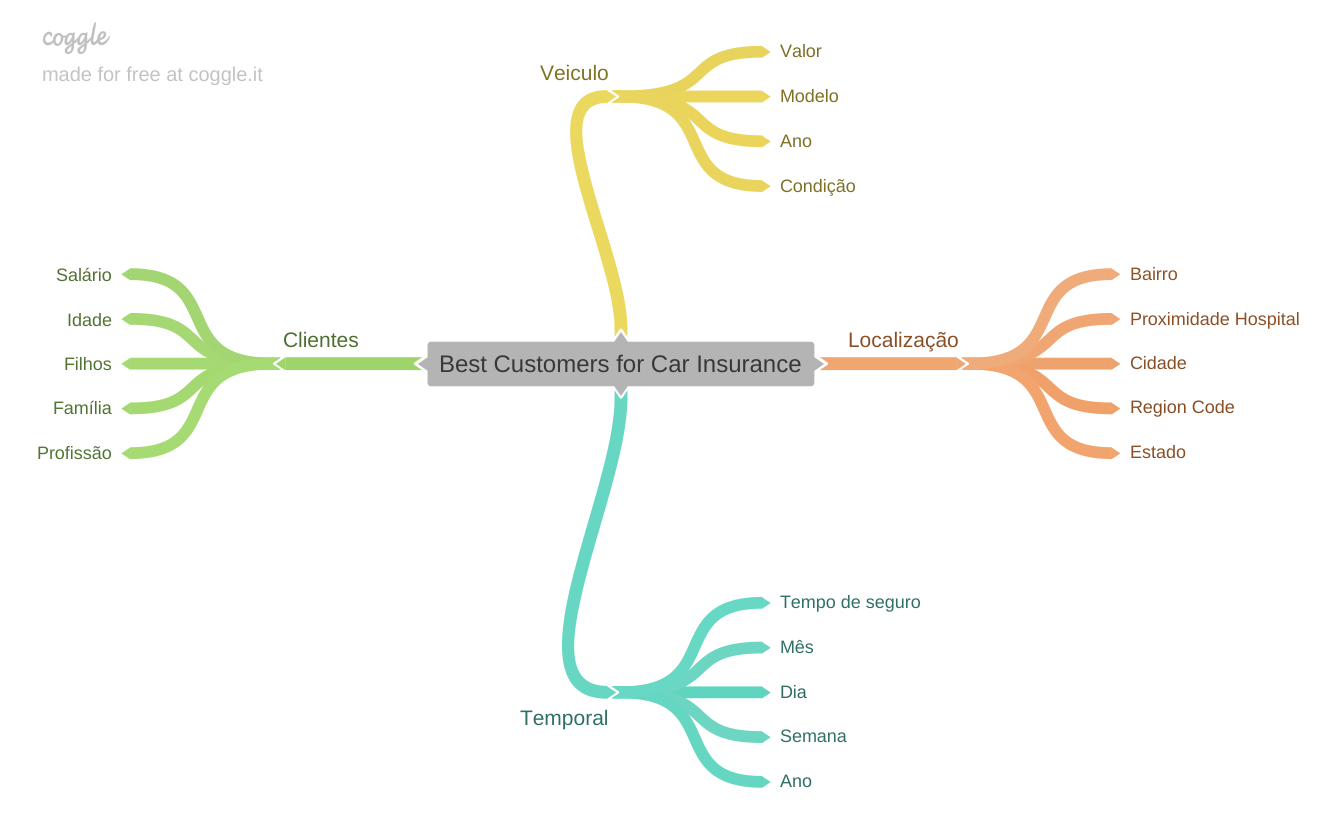

In [17]:
Image('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/reports/figures/Best_Customers_for_Car_Insurance.png')

## 2.1.1 Hipóteses Veiculo

**1.** Pessoas que possuem carro mais caros possuem maior interesse em seguro

**2.** Pessoas com carros de modelo popular possuem menos interesse em seguro

**3.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**4.** Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados


## 2.1.2 Hipóteses Cliente

**1.** Pessoas com maiores salarios possuem mais interesse em seguros

**2.** Pessoas mais velhas possuem maior interesse em seguro

**3.** Pessoas com filhos possuem maior interesse em seguro

**4.** Pessoas com familia possuem maior interesse em seguro 

## 2.1.3 Hipóteses Localização

**1.** Pessoas próximas de hospitais possuem mais interesse em seguro

**2.** Pessoas em diferentes regiões possuem maior interesse em seguro

## 2.1.4 Hipóteses Tempo

**1.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

**2.** Pessoas possuem maior interesse em seguro no inverno.

**3.** Pessoas possuem maior interesse em seguro nos dias de feriado

**4.** Existe maior interesse em seguros com o passar dos anos.

## 2.2 Lista final de hipóteses

**1.** Pessoas com carros comprados recentemente possuem maior interesse em seguro

**2.** Pessoas que o carro já foi danificado possuem maior interesse em seguro

**3.** Pessoas mais velhas possuem maior interesse em seguro

**4.** Pessoas em melhores regiões possuem maior interesse em seguro

**5.** Pessoas com mais tempo com seguro tem maior interesse em outros seguros

## 2.3 Feature Engineering

In [18]:
# adjust format into vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years'
                                                        else 'between_1_2_year' if x == '1-2 Year'
                                                        else 'below_1_year')


# Convert categorical into numeric
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x=='Yes' else 0)

# 3.0 Filtragem de variáveis

In [19]:
df3 = df2.copy()

## 3.1 Filtragem das linhas

In [20]:
# select only annual_premium bellow 65.000
df3 = df3[df3['annual_premium'] < 65000]

## 3.2 Seleção das colunas

In [21]:
# Select only who has driving license
df3 = df3[df3['driving_license'] == 1]

# drop driving license column
df3.drop(columns='driving_license', inplace=True)

# 4.0 Análise exploratória dos dados

In [22]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

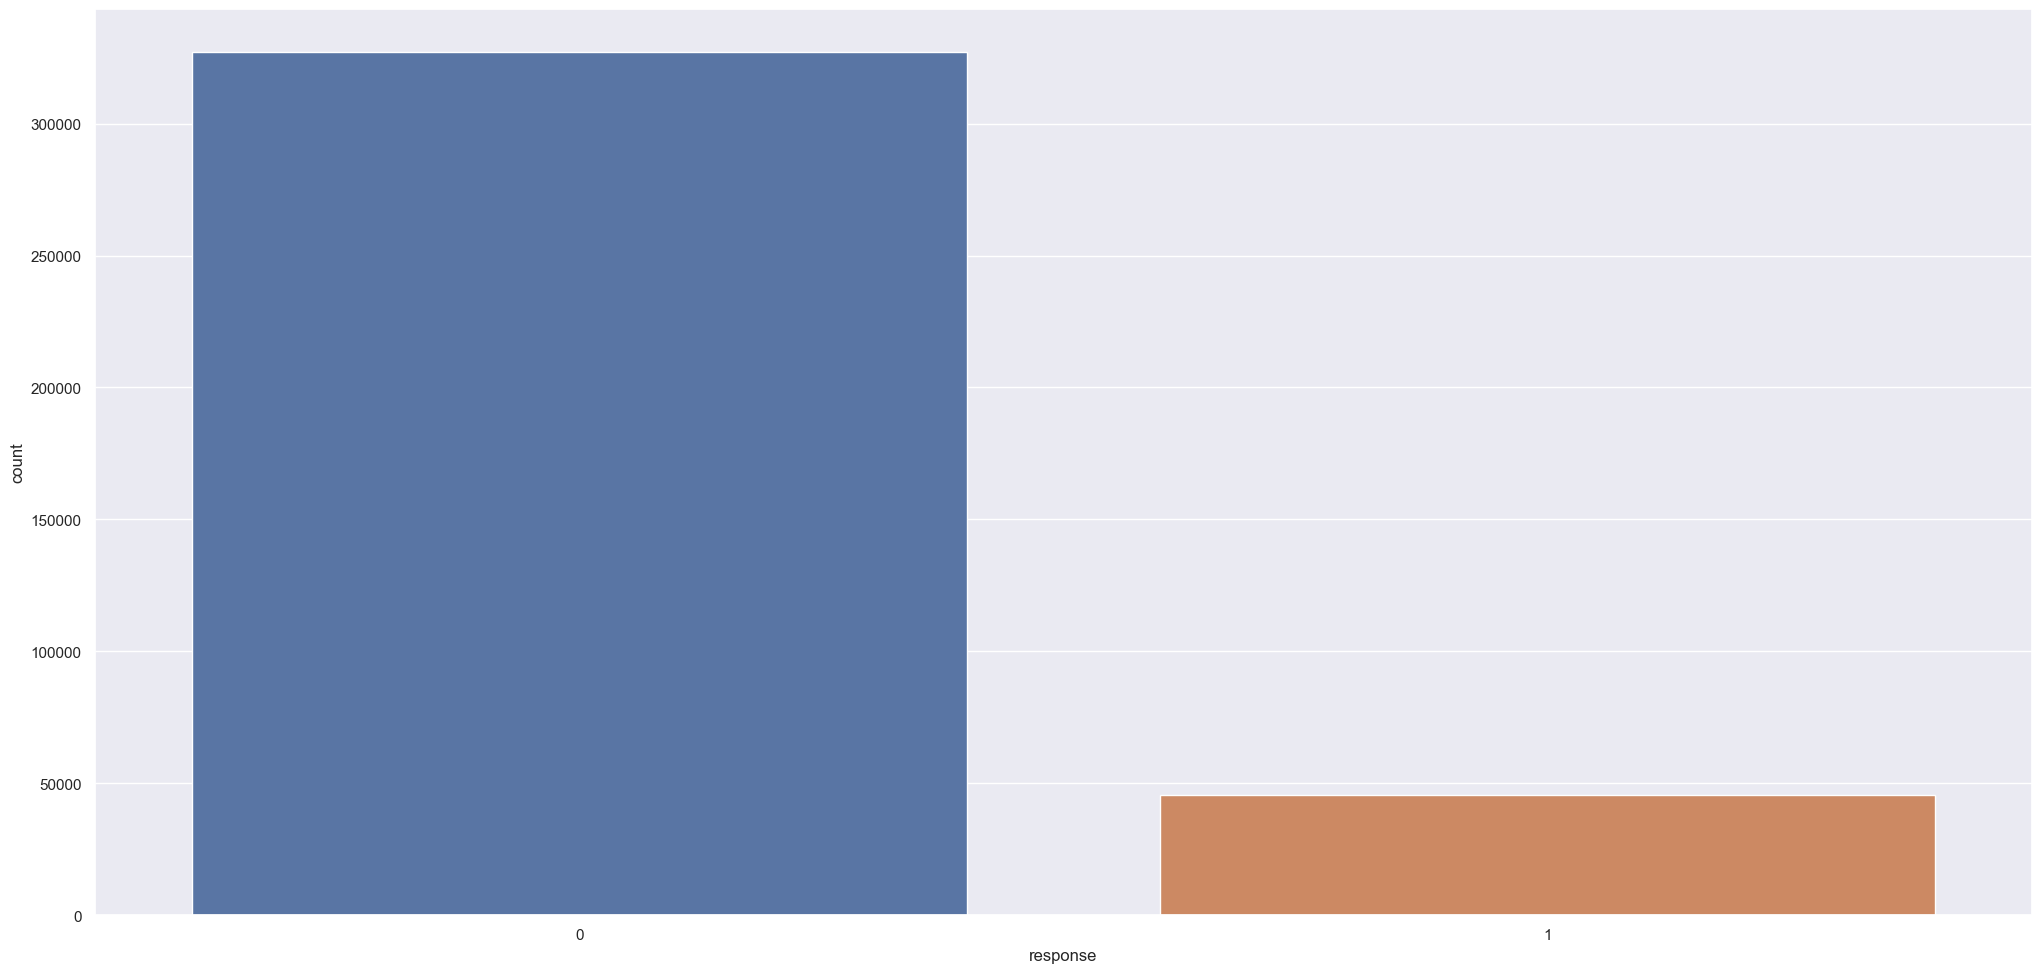

In [23]:
sns.countplot(x='response', data=df4);

### 4.1.2 Numerical Variable

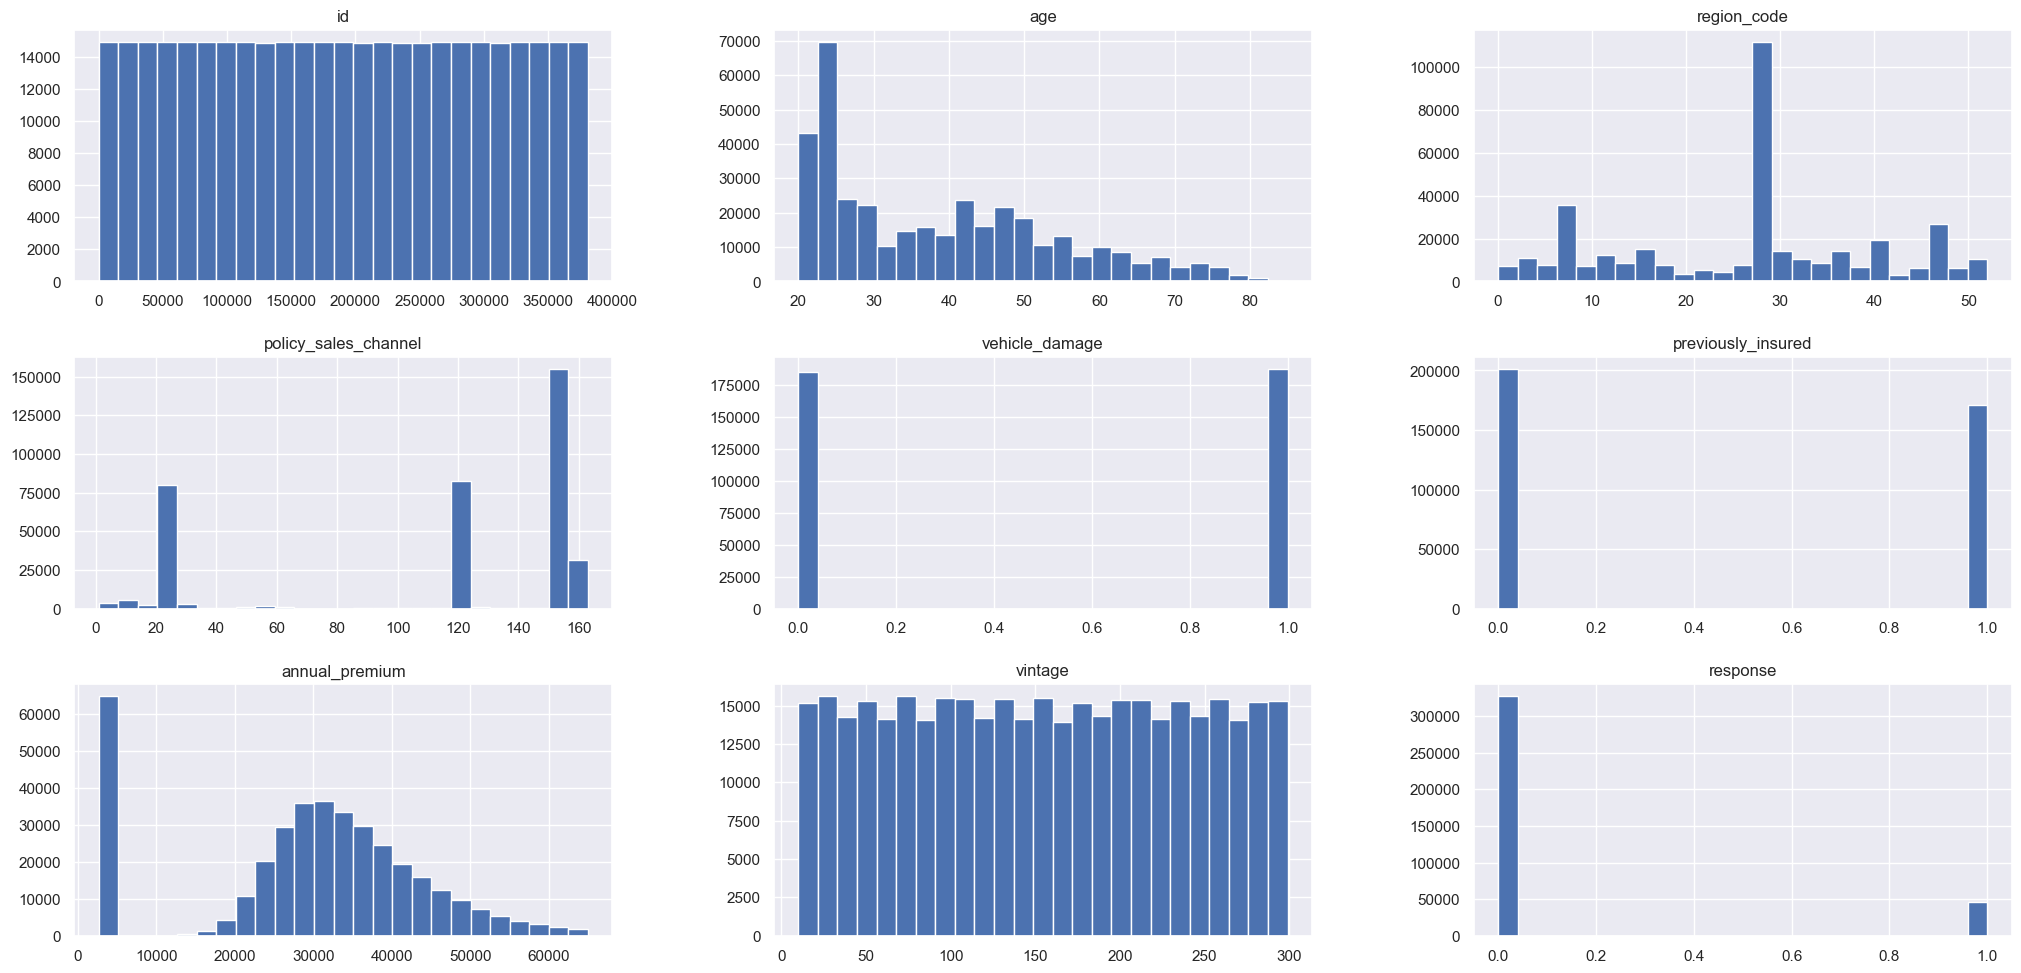

In [24]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

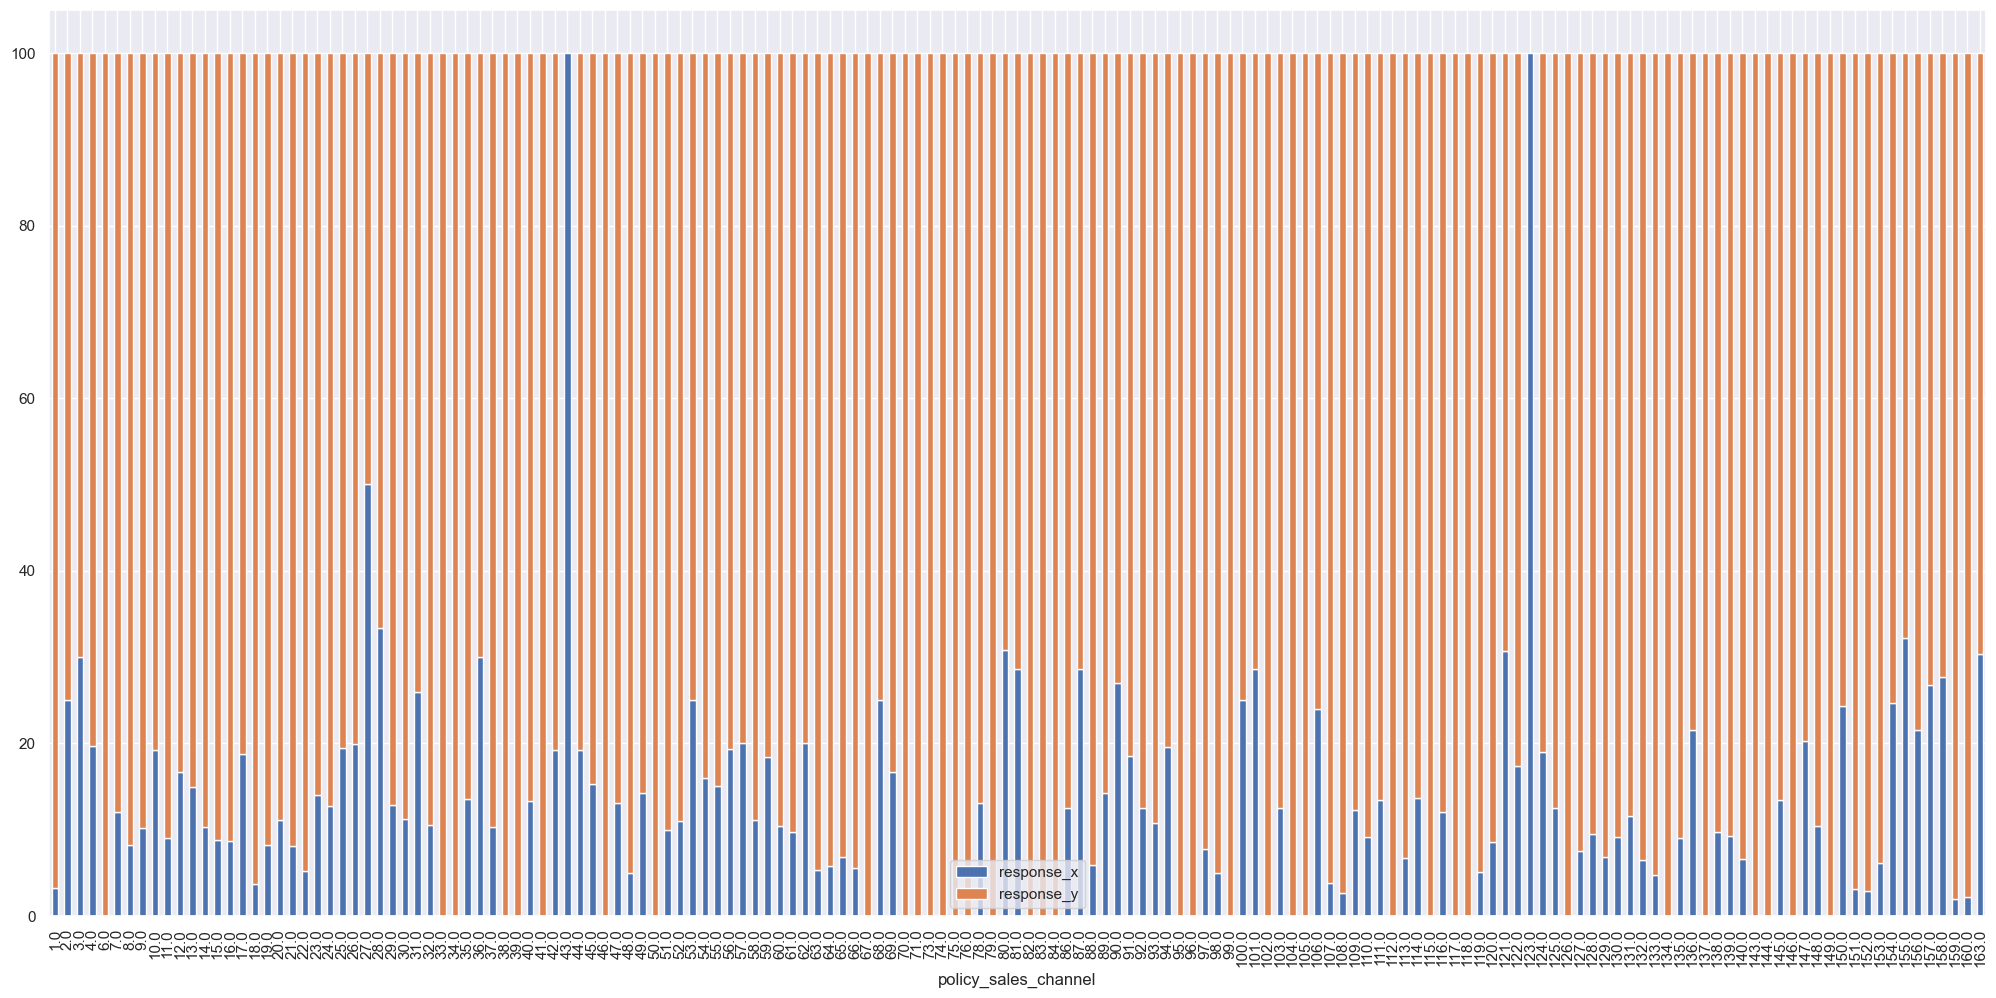

In [25]:
#policy_sales_channel
# count responses per channel
aux01 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
aux02 = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').count().reset_index()

# merge and make percentage
aux03 = pd.merge(aux01, aux02, how='inner', on='policy_sales_channel')
aux03['response_x'] = aux03.apply(lambda x: x['response_x'] / x['response_y'] * 100, axis=1)
aux03['response_y'] = aux03.apply(lambda x: 100 - x['response_x'], axis=1)

# plot
aux03.plot(x = 'policy_sales_channel', kind = 'bar', stacked = True);

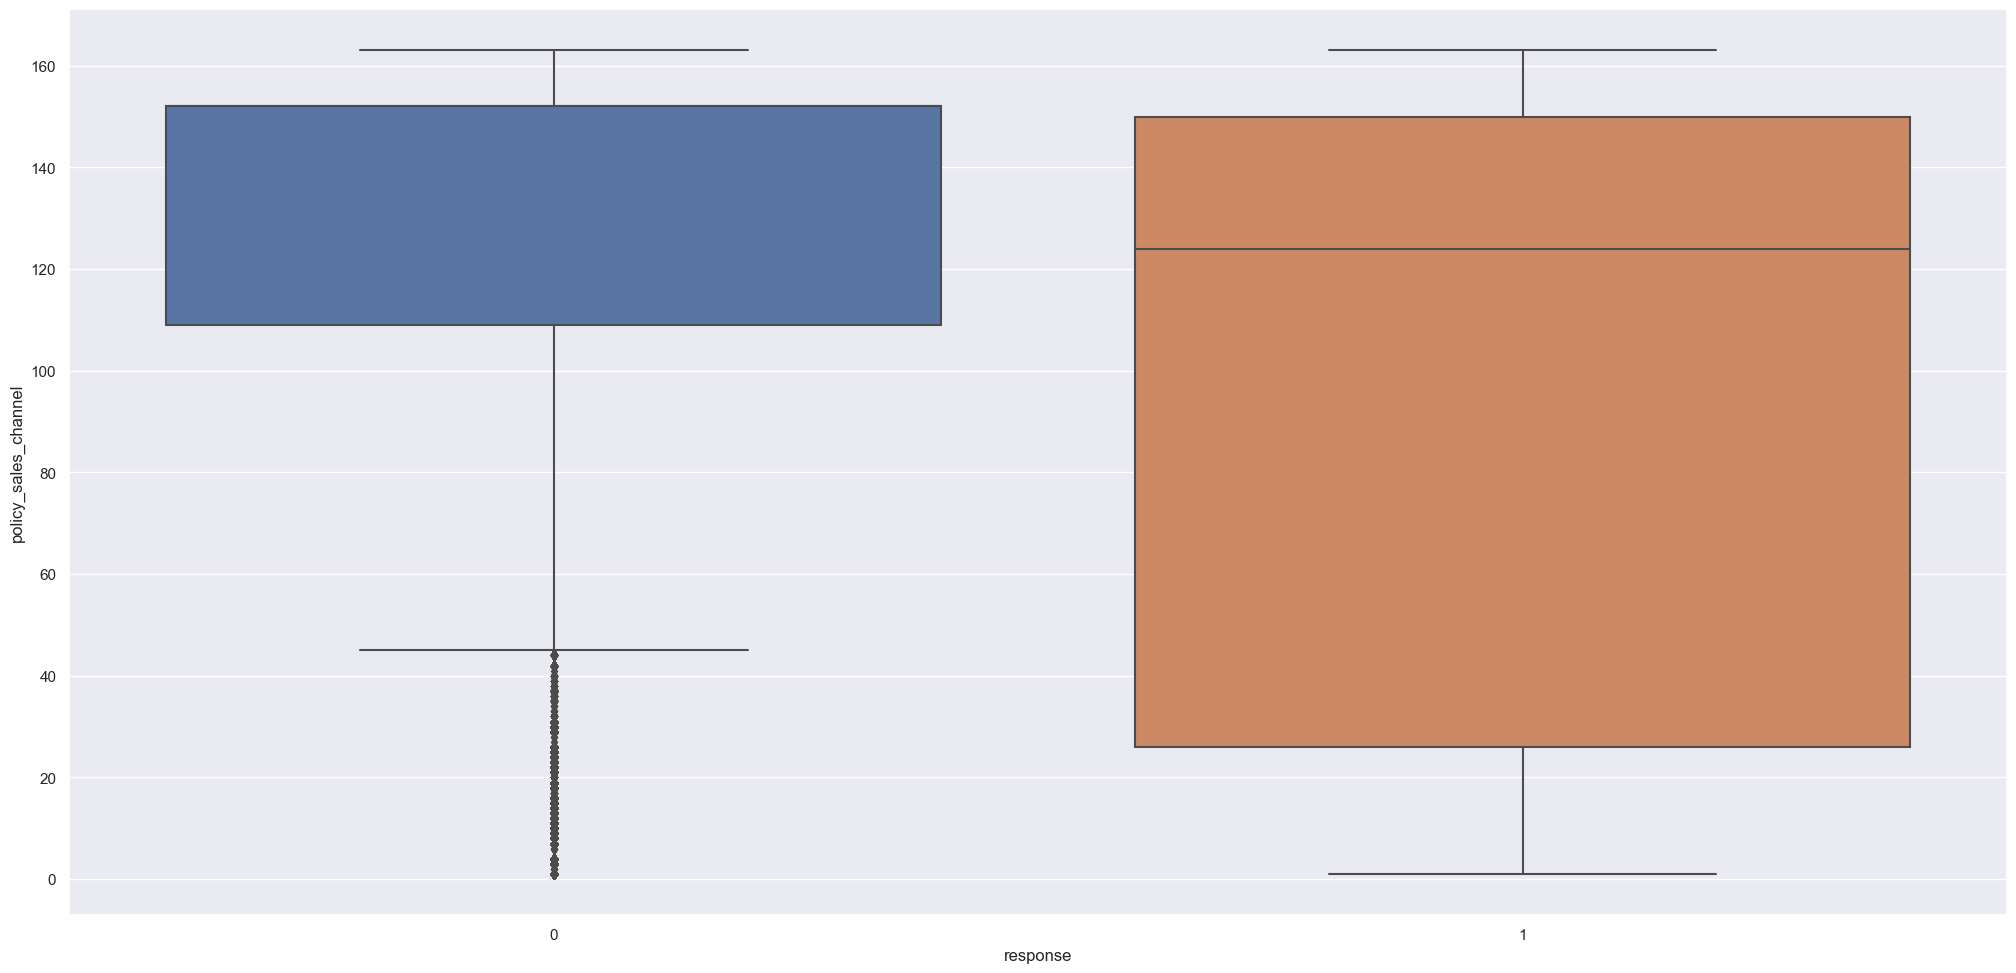

In [26]:
sns.boxplot(x='response', y='policy_sales_channel', data=df4);

In [27]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x : x / x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.775,0.225
1,0.999,0.001


### 4.1.3 Categorical Variable

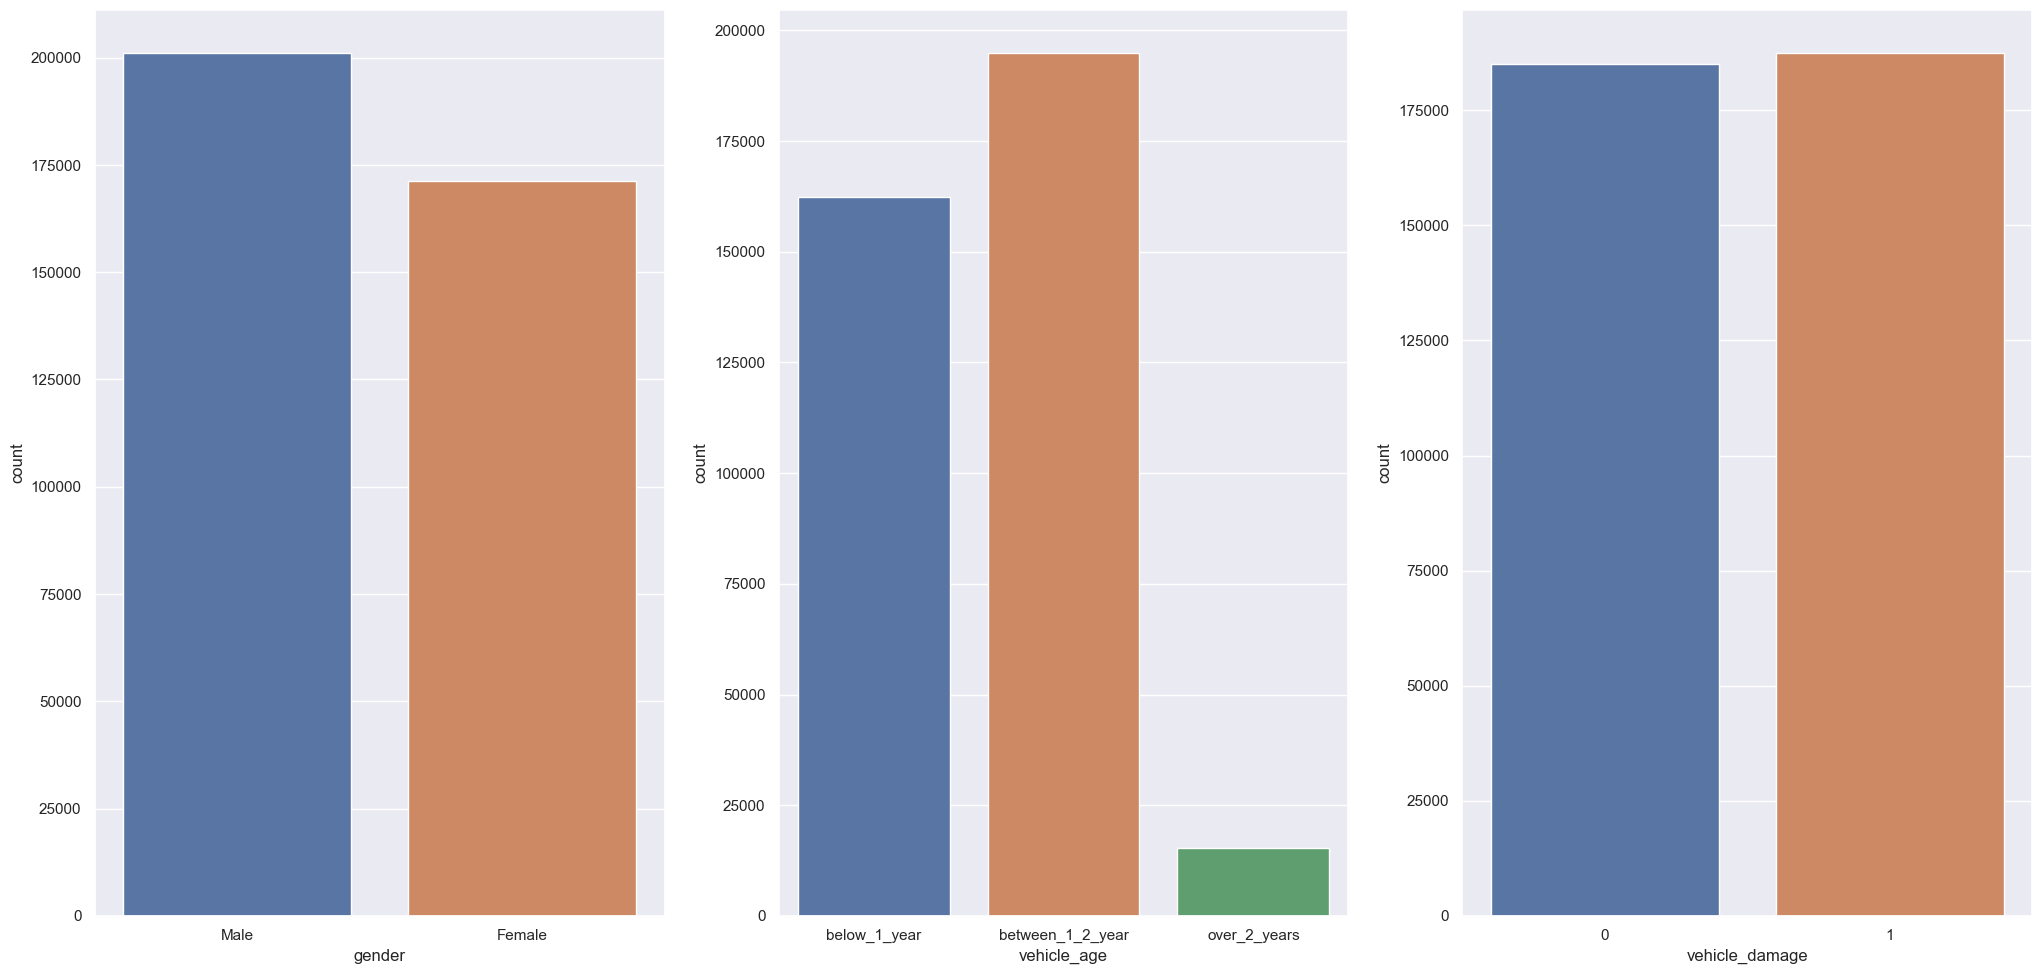

In [28]:
# gender
plt.subplot (1, 3, 1)
sns.countplot(x='gender', data=df4)

# vehicle_age
plt.subplot (1, 3, 2)
sns.countplot(x='vehicle_age', data=df4)

# vehicle_damage
plt.subplot (1, 3, 3)
sns.countplot(x='vehicle_damage', data=df4);

## 4.2 Análise Bivariada

### H1. Pessoas com carros comprados recentemente possuem maior interesse em seguro
**FALSA** Pessoas com carros antigos possuem maior interesse em seguro

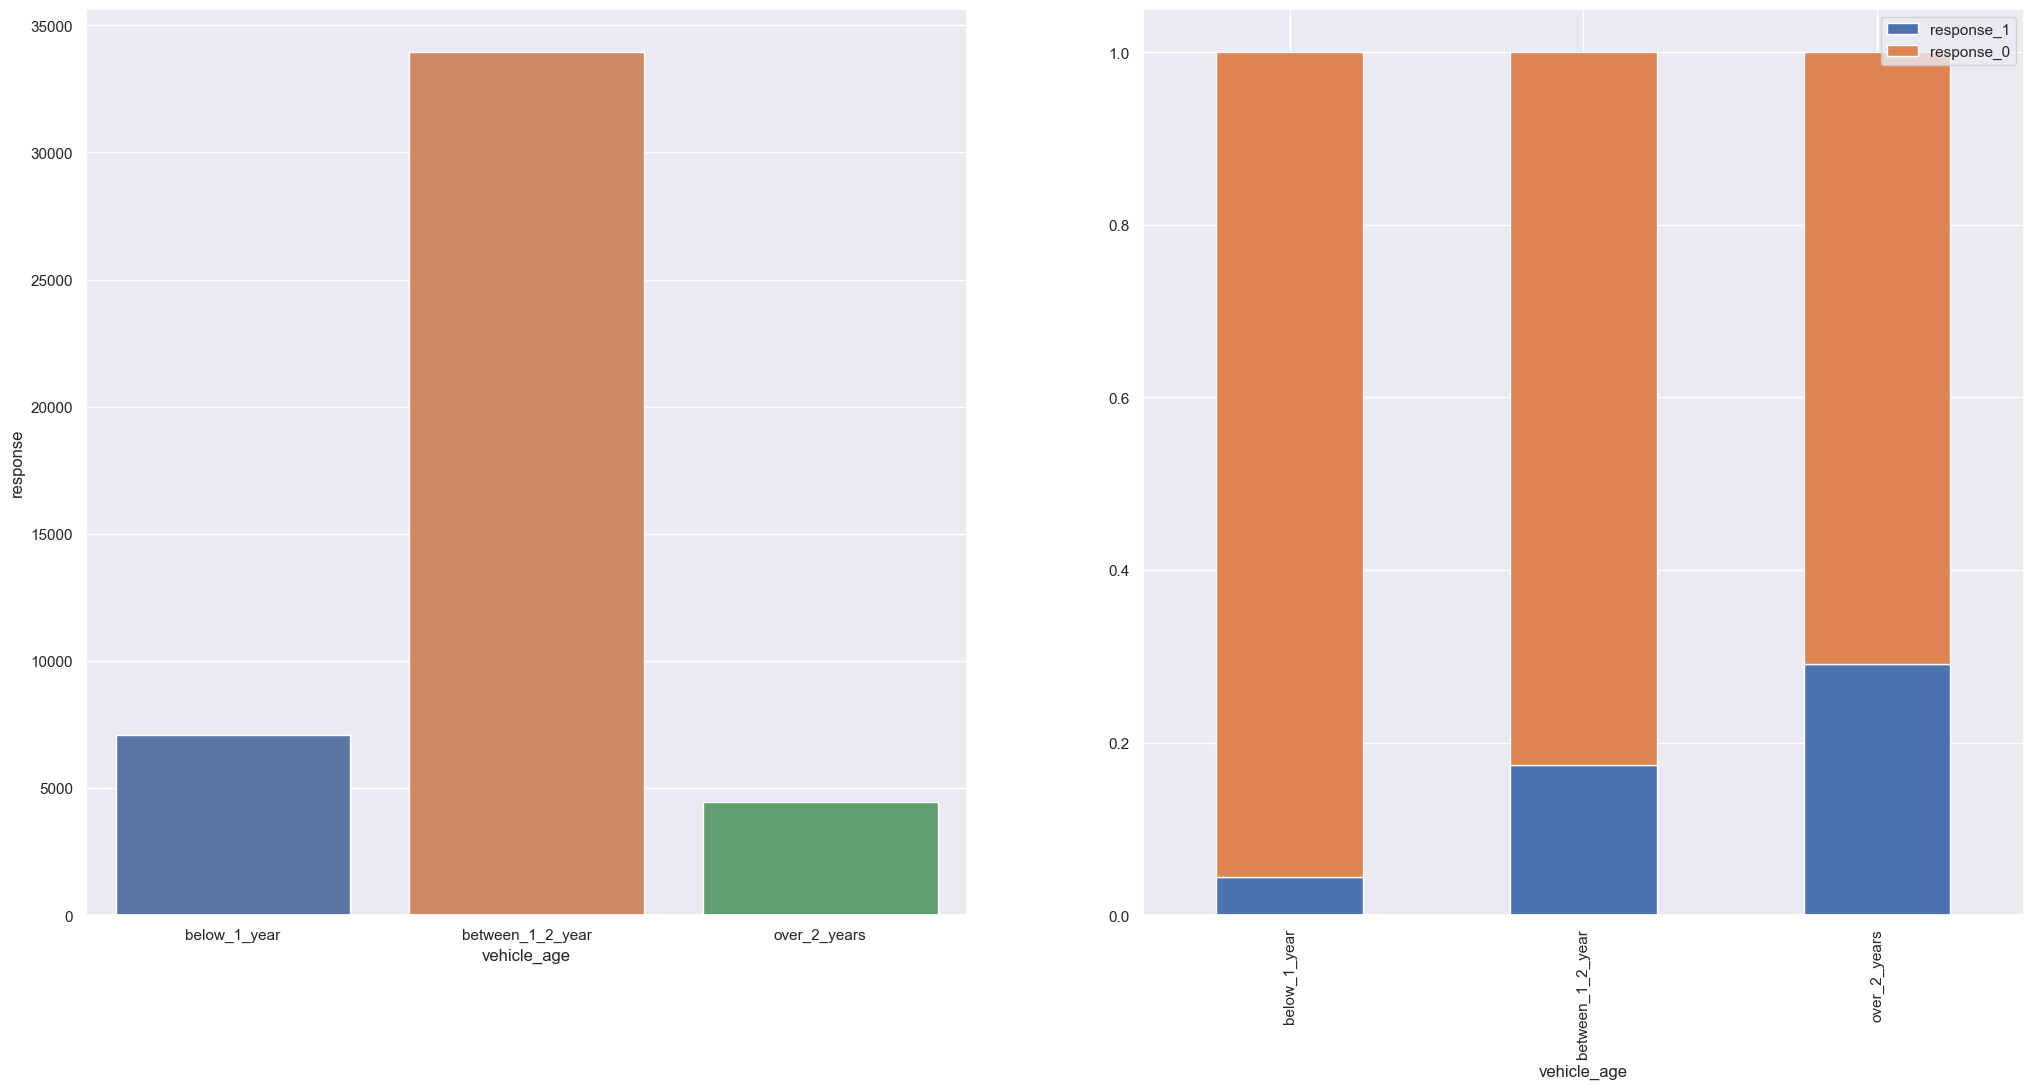

In [29]:
# plot for absolute response per vehicle age
plt.subplot(1, 2, 1)

aux01 = df4[['vehicle_age', 'response']].groupby('vehicle_age').sum().reset_index()
sns.barplot(x='vehicle_age', y='response', data=aux01);

# plot for percentages response per vehicle age
ax = plt.subplot(1, 2, 2)

aux02 = pd.crosstab(df4['vehicle_age'], df4['response']).apply(lambda x: x / x.sum(), axis=1).reset_index()
columns = ['vehicle_age', 'response_0', 'response_1']
aux02.columns = columns
aux02 = aux02[['vehicle_age', 'response_1', 'response_0']]

aux02.plot(x = 'vehicle_age', kind = 'bar', stacked = True, ax=ax);

### H2. Pessoas que o carro já foi danificado possuem maior interesse em seguro em relação aos que não foram danificados
**VERDADEIRA** Pessoas que tiveram o carro danificado demontram maior interesse em seguro, entretanto a maioria ainda não prefere.

In [30]:
aux1 = pd.crosstab(df4['vehicle_damage'], df4['response'])
aux1.apply(lambda x: x / x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.995,0.005
1,0.763,0.237


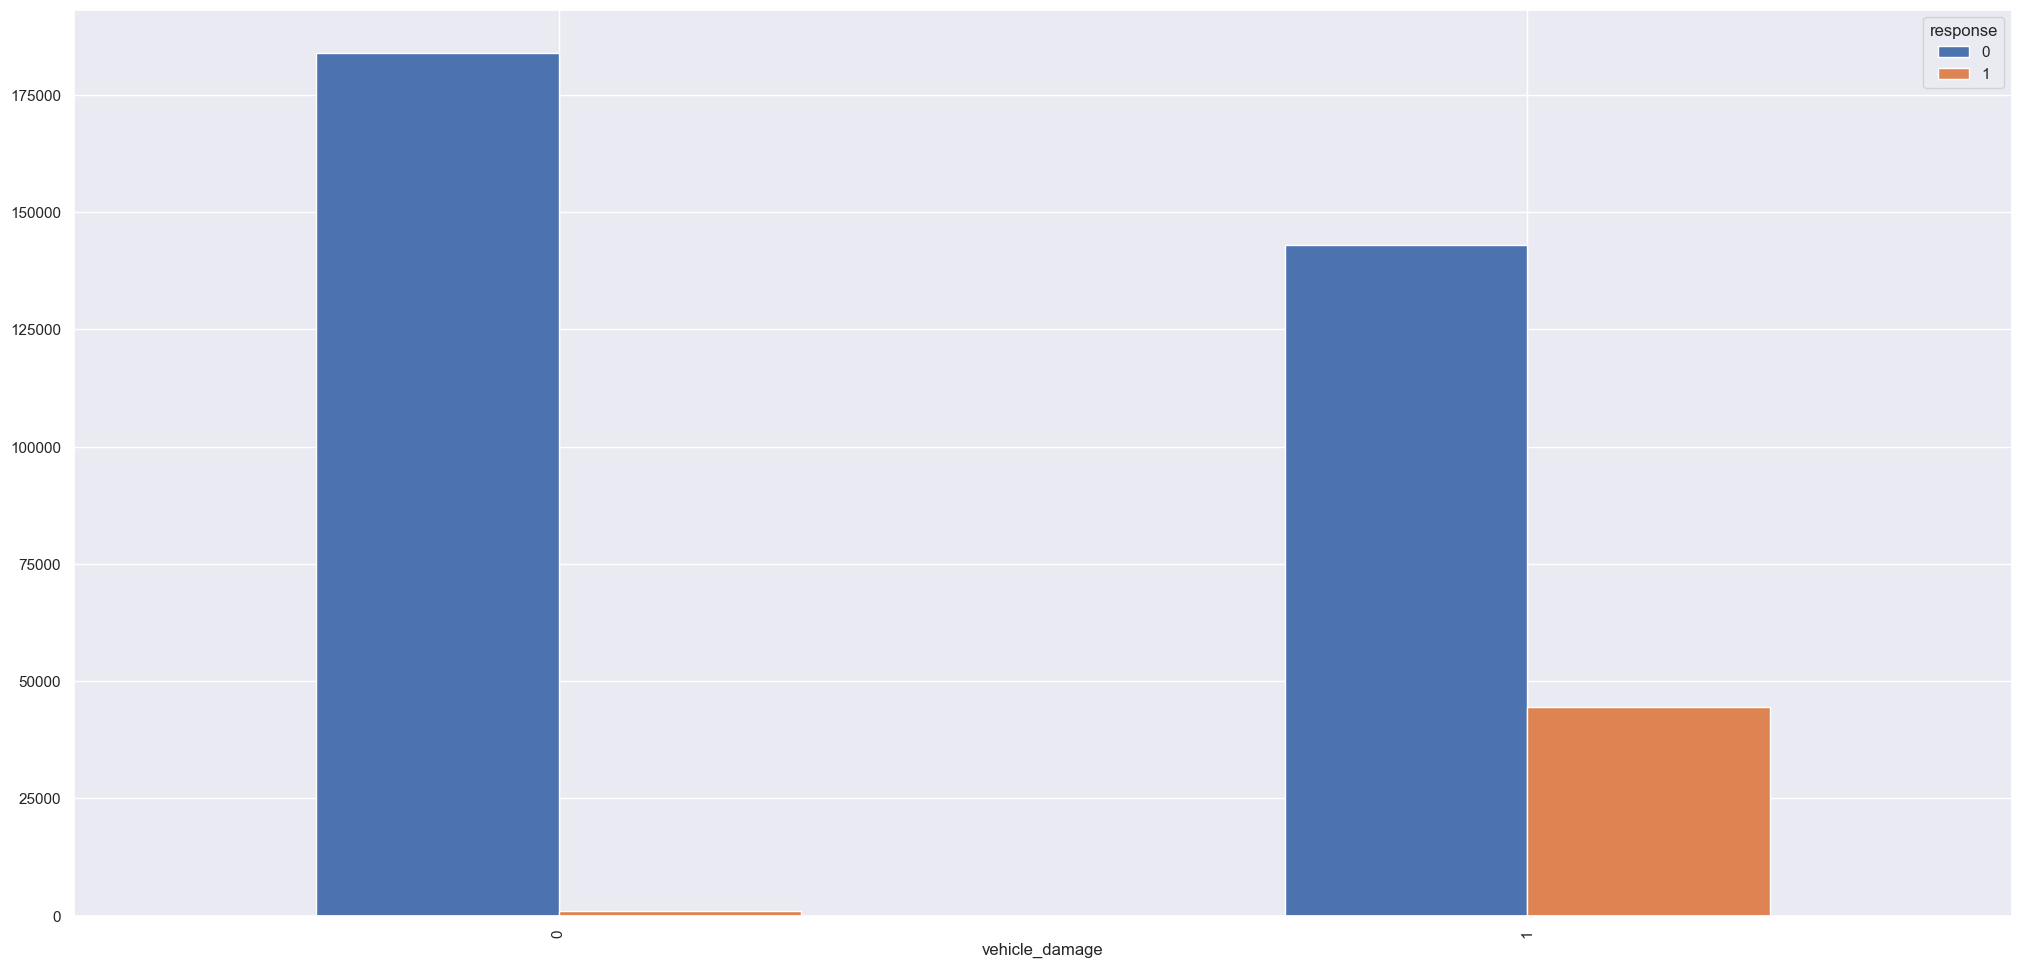

In [31]:
aux1.plot(kind='bar');

### H3. Pessoas mais velhas possuem maior interesse em seguro
**FALSO** Pessoas mais velhas possuem menor interesse em seguro a partir de 40 anos.

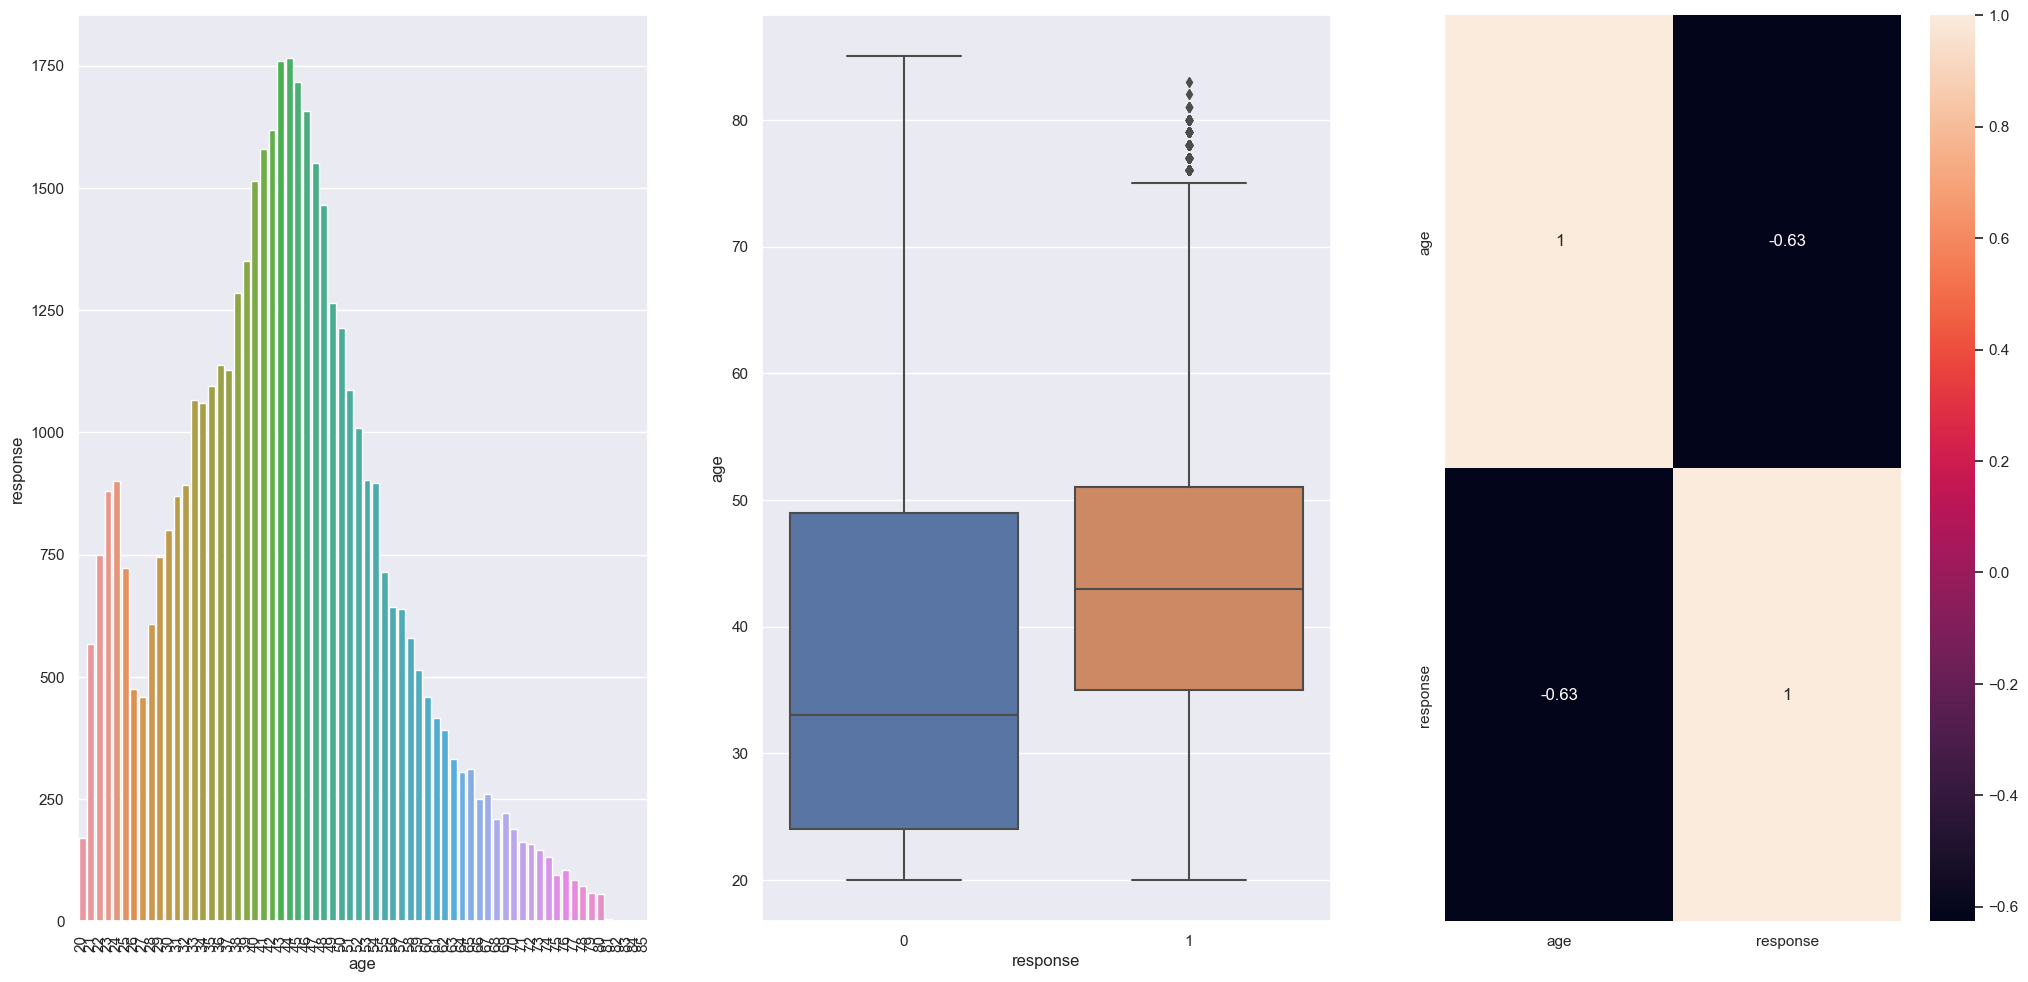

In [32]:
plt.subplot(1, 3, 1)
aux1 = df4[['age', 'response']].groupby('age').sum().reset_index()
sns.barplot(x='age', y='response', data=aux1)
plt.xticks(rotation=90)

plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Pessoas em diferentes regiões possuem maior interesse em seguro
**VERDADEIRA** Existem regiões com maiores interesse em seguro.

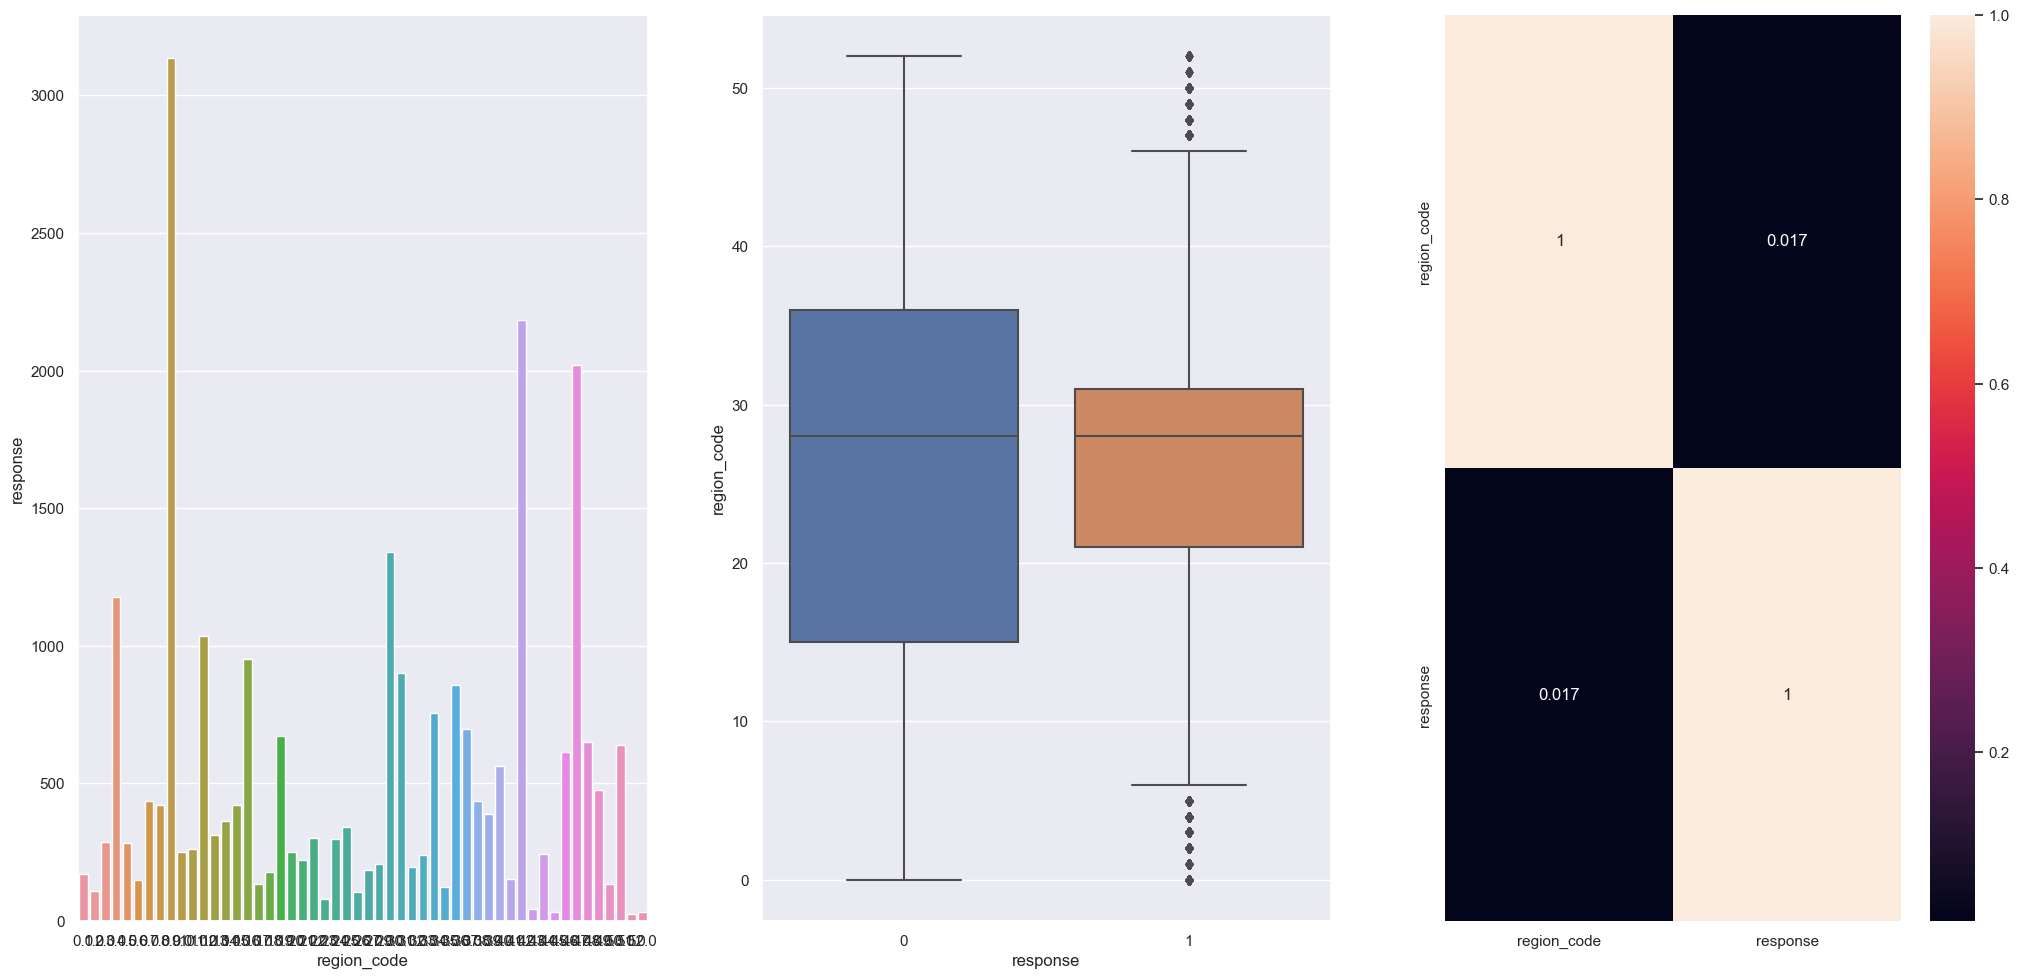

In [33]:
plt.subplot(1, 3, 1)
aux1 = df4[['region_code', 'response']].groupby('region_code').sum().reset_index()
aux2 = aux1[aux1['response'] < 4000]

sns.barplot(x='region_code', y='response', data=aux2)

plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='region_code', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H5. Pessoas com mais tempo com seguro tem maior interesse em outros seguros
**FALSA** Pessoas com maior tempo de seguro são indiferentes das com menores tempos.

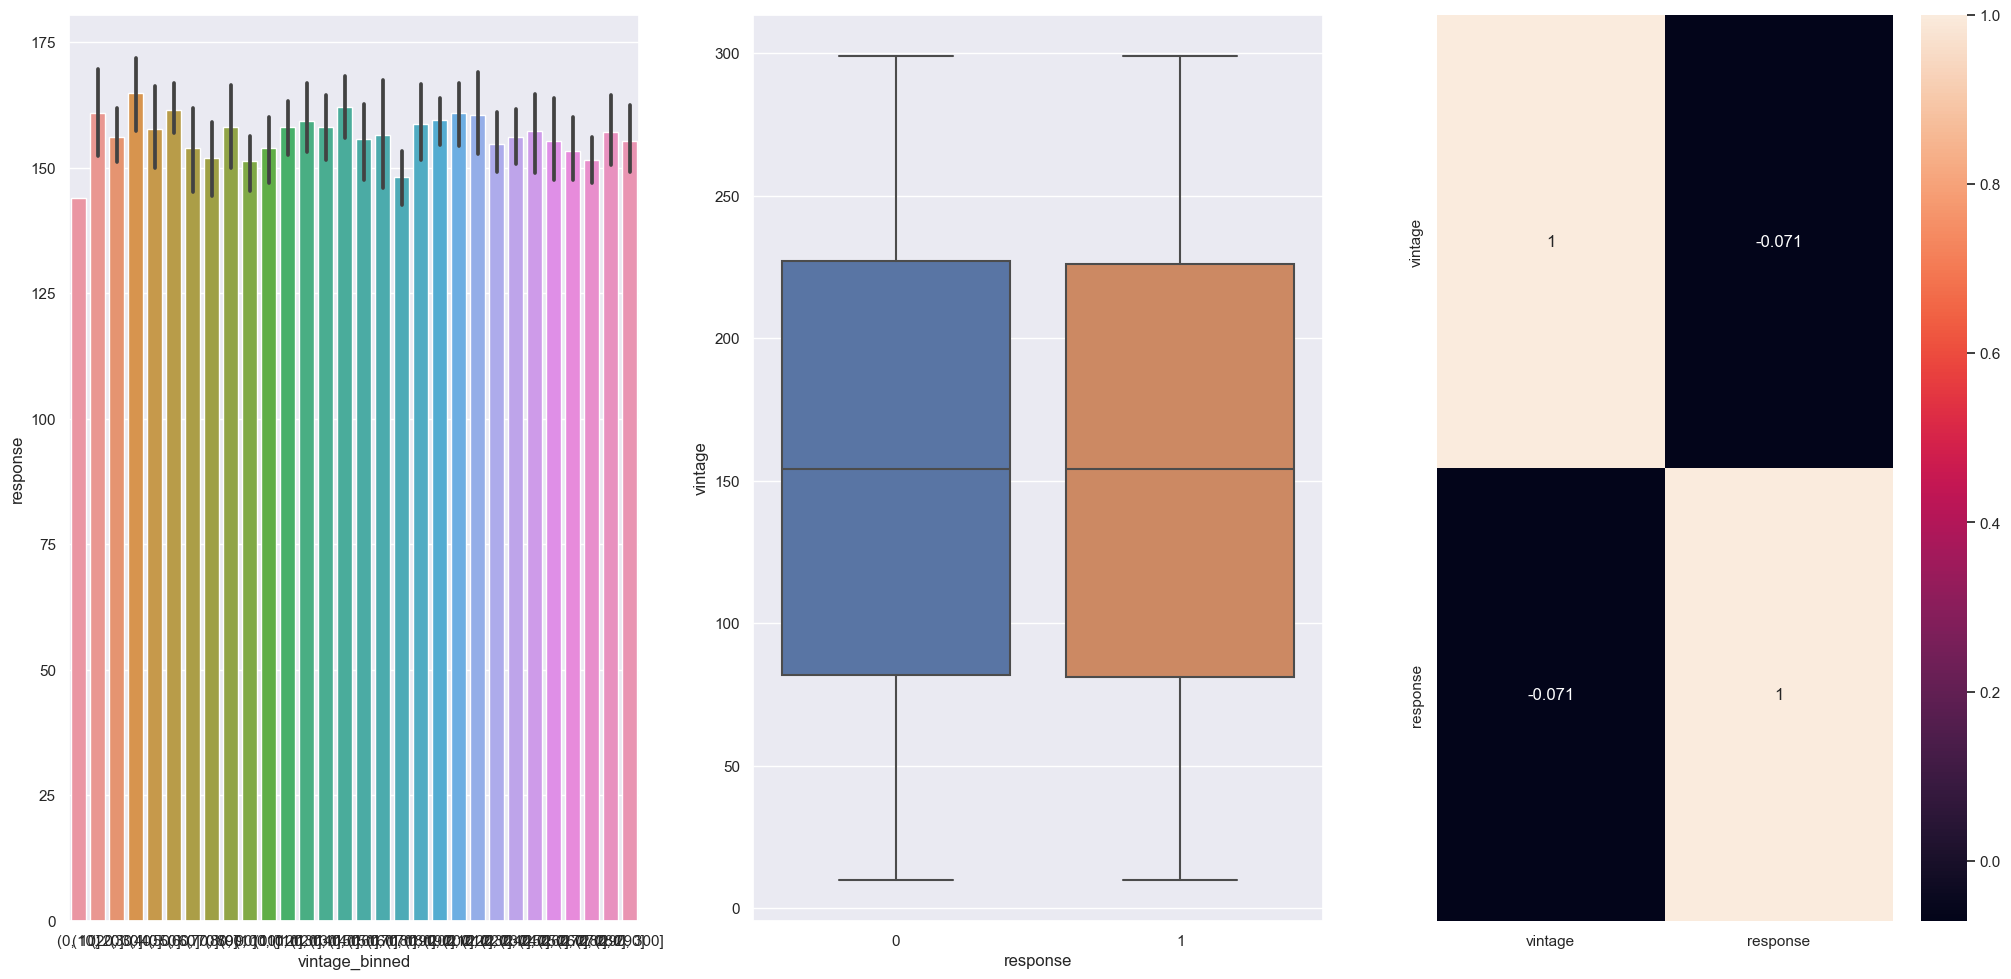

In [34]:
plt.subplot(1, 3, 1)
aux1 = df4[['vintage', 'response']].groupby('vintage').sum().sort_values('vintage').reset_index()
bins = list(np.arange(0, 310, 10))
aux1['vintage_binned'] = pd.cut(aux1['vintage'], bins = bins)

sns.barplot(x='vintage_binned', y='response', data=aux1)


plt.subplot(1, 3, 2)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### 4.2.1 Resumo das Hipóteses

In [35]:
tab = [['Hipóteses', 'Conclusão', 'Relevância'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Verdadeira', 'Médio'],
       ['H3', 'Falsa', 'Alto'],
       ['H4', 'Verdadeira', 'Baixa'],
       ['H5', 'Falsa', 'Baixa'],
      ]
print(tabulate(tab, headers='firstrow'))

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Verdadeira   Médio
H3           Falsa        Alto
H4           Verdadeira   Baixa
H5           Falsa        Baixa


## 4.3 Análise Multivariada

### 4.3.1 Atributos numéricos

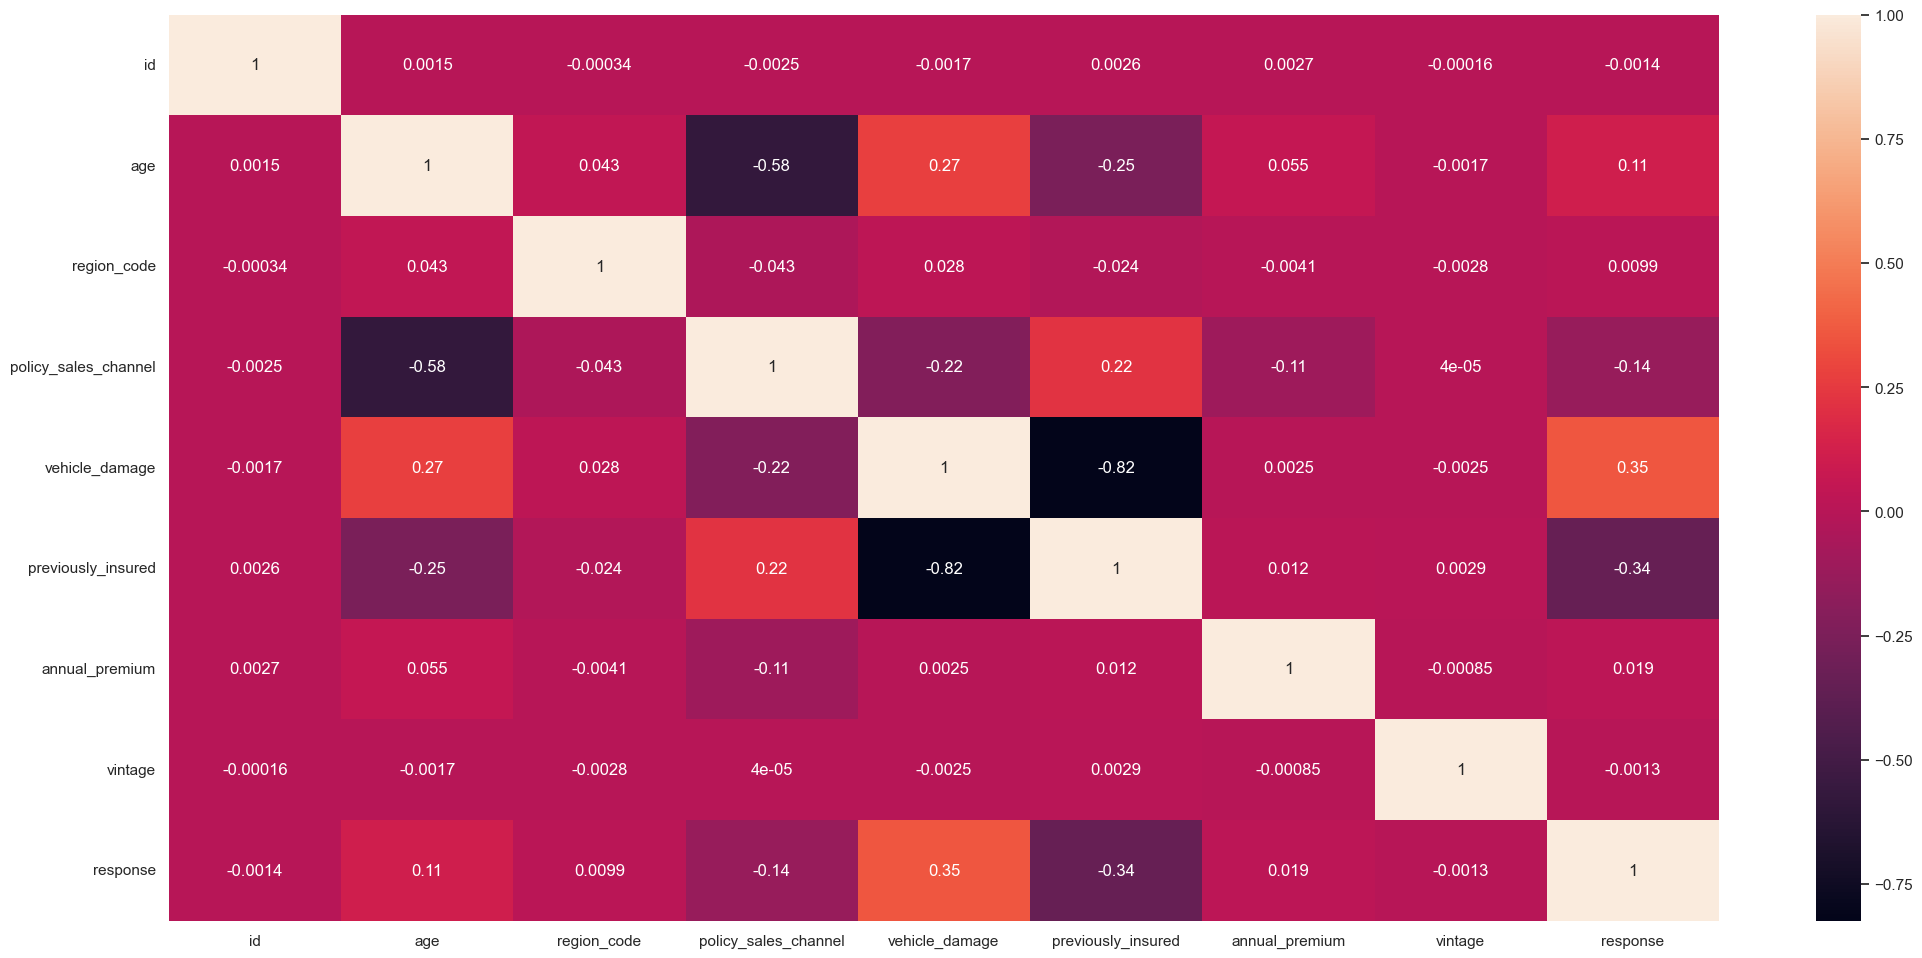

In [36]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Atributos categóricos

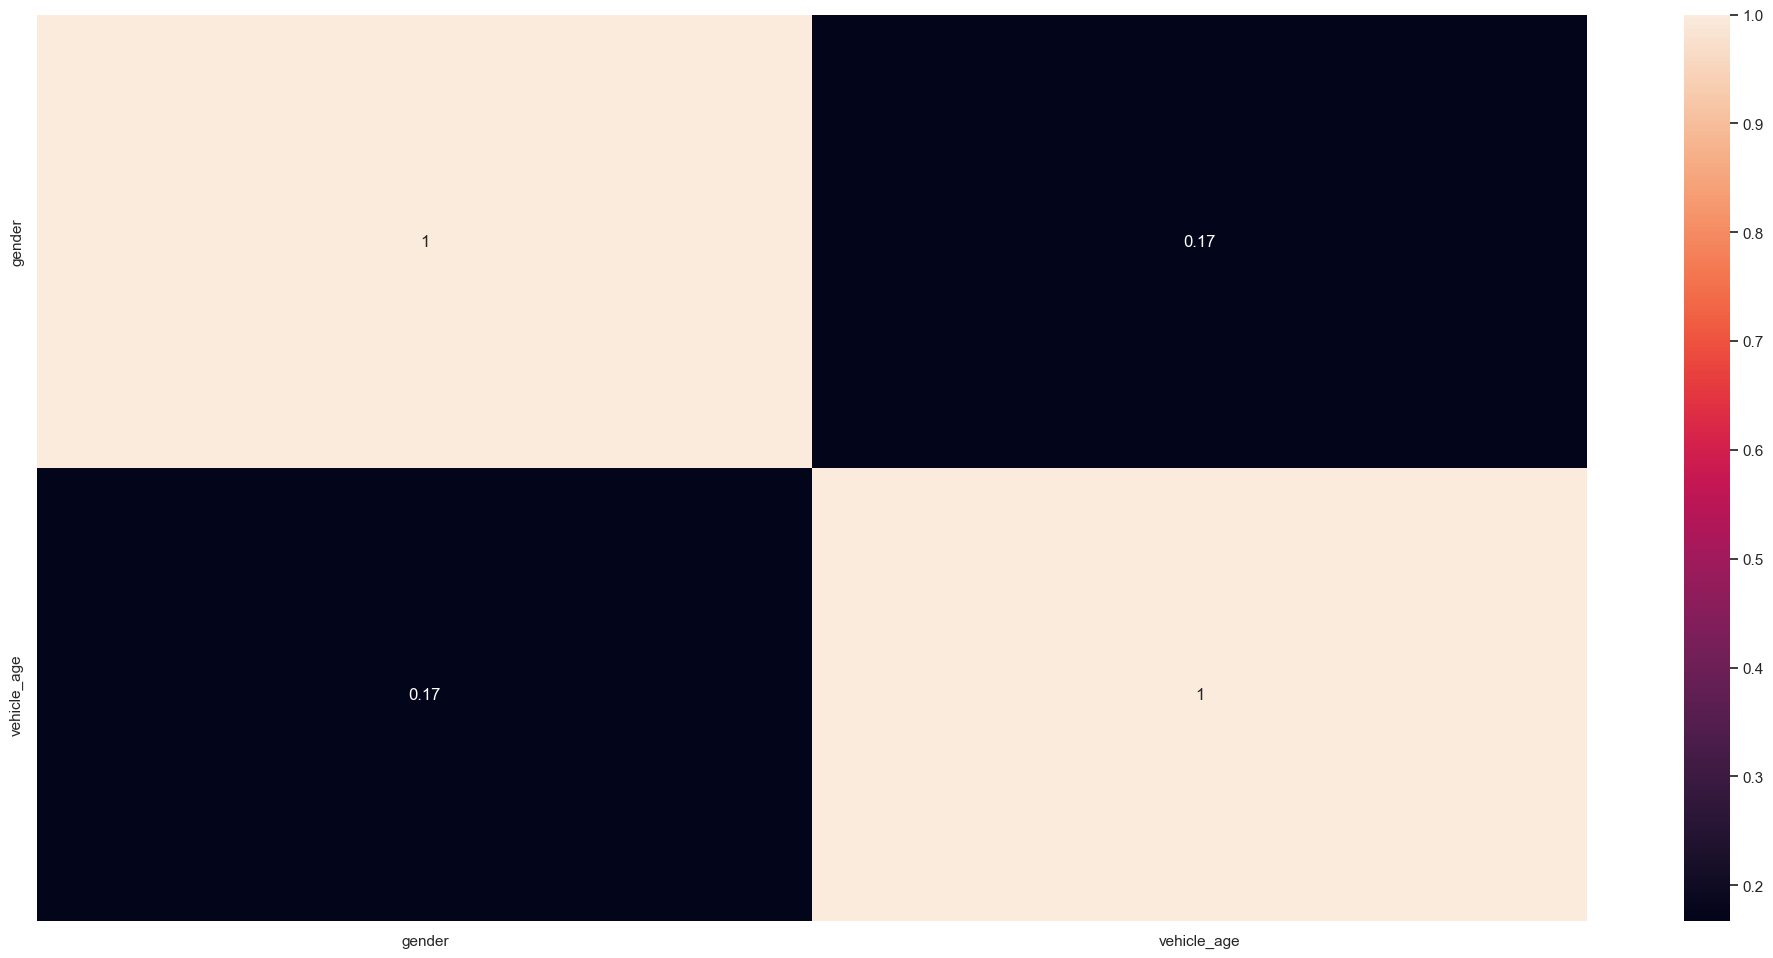

In [37]:
# only categorical data
a = df4.select_dtypes(include='object')

# Cramer V correlation
d = pycorrcat.corr_matrix(a, ['gender', 'vehicle_age'])
sns.heatmap(d, annot=True);

# 5.0 Preparação dos dados

In [38]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)

df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [39]:
ss = pp.StandardScaler()

# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)

## 5.2 Rescaling

In [40]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df5['age'] = mms_age.fit_transform(df5[['age']].values)

# Vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)

## 5.3 Transformação

### 5.3.1 Encoding

In [41]:
# gender - Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map(target_encode_gender)

# region_code - Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)

# 6.0 Feature Selection

## 6.1 Validation data preparation

In [42]:
# annual_premium
x_val.loc[:, 'annual_premium'] = ss.transform(x_val[['annual_premium']].values)

# Age
x_val.loc[:, 'age'] = mms_age.transform(x_val[['age']].values)

# Vintage
x_val.loc[:, 'vintage'] = mms_vintage.transform(x_val[['vintage']].values)

# gender - Target Encoding
x_val.loc[:, 'gender'] = x_val.loc[:, 'gender'].map(target_encode_gender)

# region_code - Target Encoding
x_val.loc[:, 'region_code'] = x_val.loc[:, 'region_code'].map(target_encode_region_code)

# vehicle_age - One Hot Encoding
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:, 'policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)


## 6.2 feature selection per importance

In [43]:
# model definition
#forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# saving model
#pickle.dump(forest, open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl', 'wb'))

In [44]:
# loading model selector
file = open('F:/SamuelOliveiraAlvesd/Desktop/Data_Science/Projetos/Health_Insurance_Cross_Sell/models/extra_tree_selector.pkl','rb')
forest = pickle.load(file)
file.close()


# data preparation
x_train_f = df5.drop(['id', 'response'], axis=1)
y_train_f = y_train.values
forest.fit(x_train_f, y_train_f)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                        feature  importance
0                       vintage       0.273
0                annual_premium       0.229
0                           age       0.170
0                   region_code       0.112
0                vehicle_damage       0.070
0          policy_sales_channel       0.063
0            previously_insured       0.055
0      vehicle_age_below_1_year       0.013
0  vehicle_age_between_1_2_year       0.007
0                        gender       0.006
0      vehicle_age_over_2_years       0.002


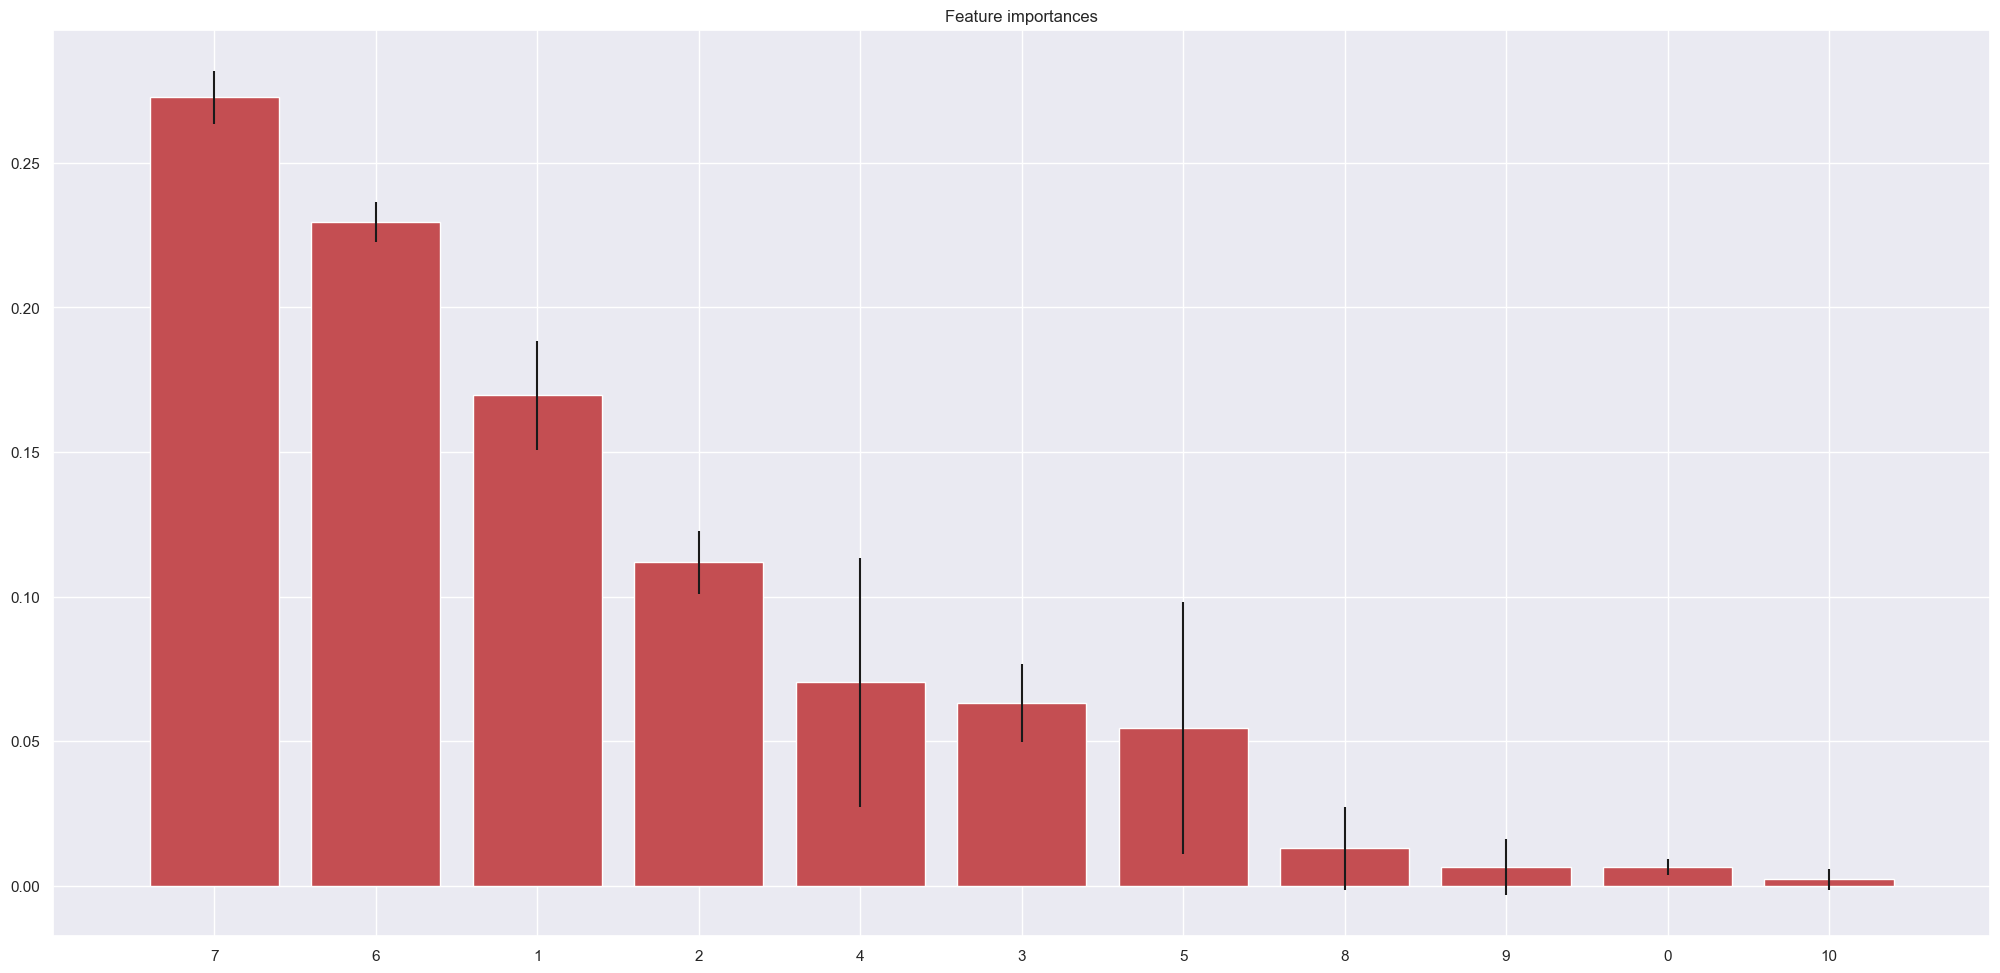

In [45]:
# Collect features from model selector
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Organize and print ranking per features
print('Feature ranking:')
df = pd.DataFrame()
for i, j in zip(x_train_f, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature importances')
plt.bar(range(x_train_f.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_f.shape[1]), indices)
plt.xlim([-1, x_train_f.shape[1]])
plt.show()

# 7.0 Machine Learning Modeling

In [46]:
# select features from ML
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# Dataframe for metrics
x_validation = x_val.copy()
y_validation = y_val.copy()

# Dataframe for ML
x_train = df5[cols_selected]
x_val = x_val[cols_selected]

## 7.1 K-Nearest Neighbors

In [47]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization
yhat_knn = knn_model.predict_proba(x_val)
yhatp_knn = knn_model.predict( x_val )


# ---------- Metrics ------------------
# Accuracy score
ba_knn = balanced_accuracy_score(y_val, yhatp_knn)

print(f'Accuracy from balanced score is: {ba_knn:.3f}')

Accuracy from balanced score is: 0.550


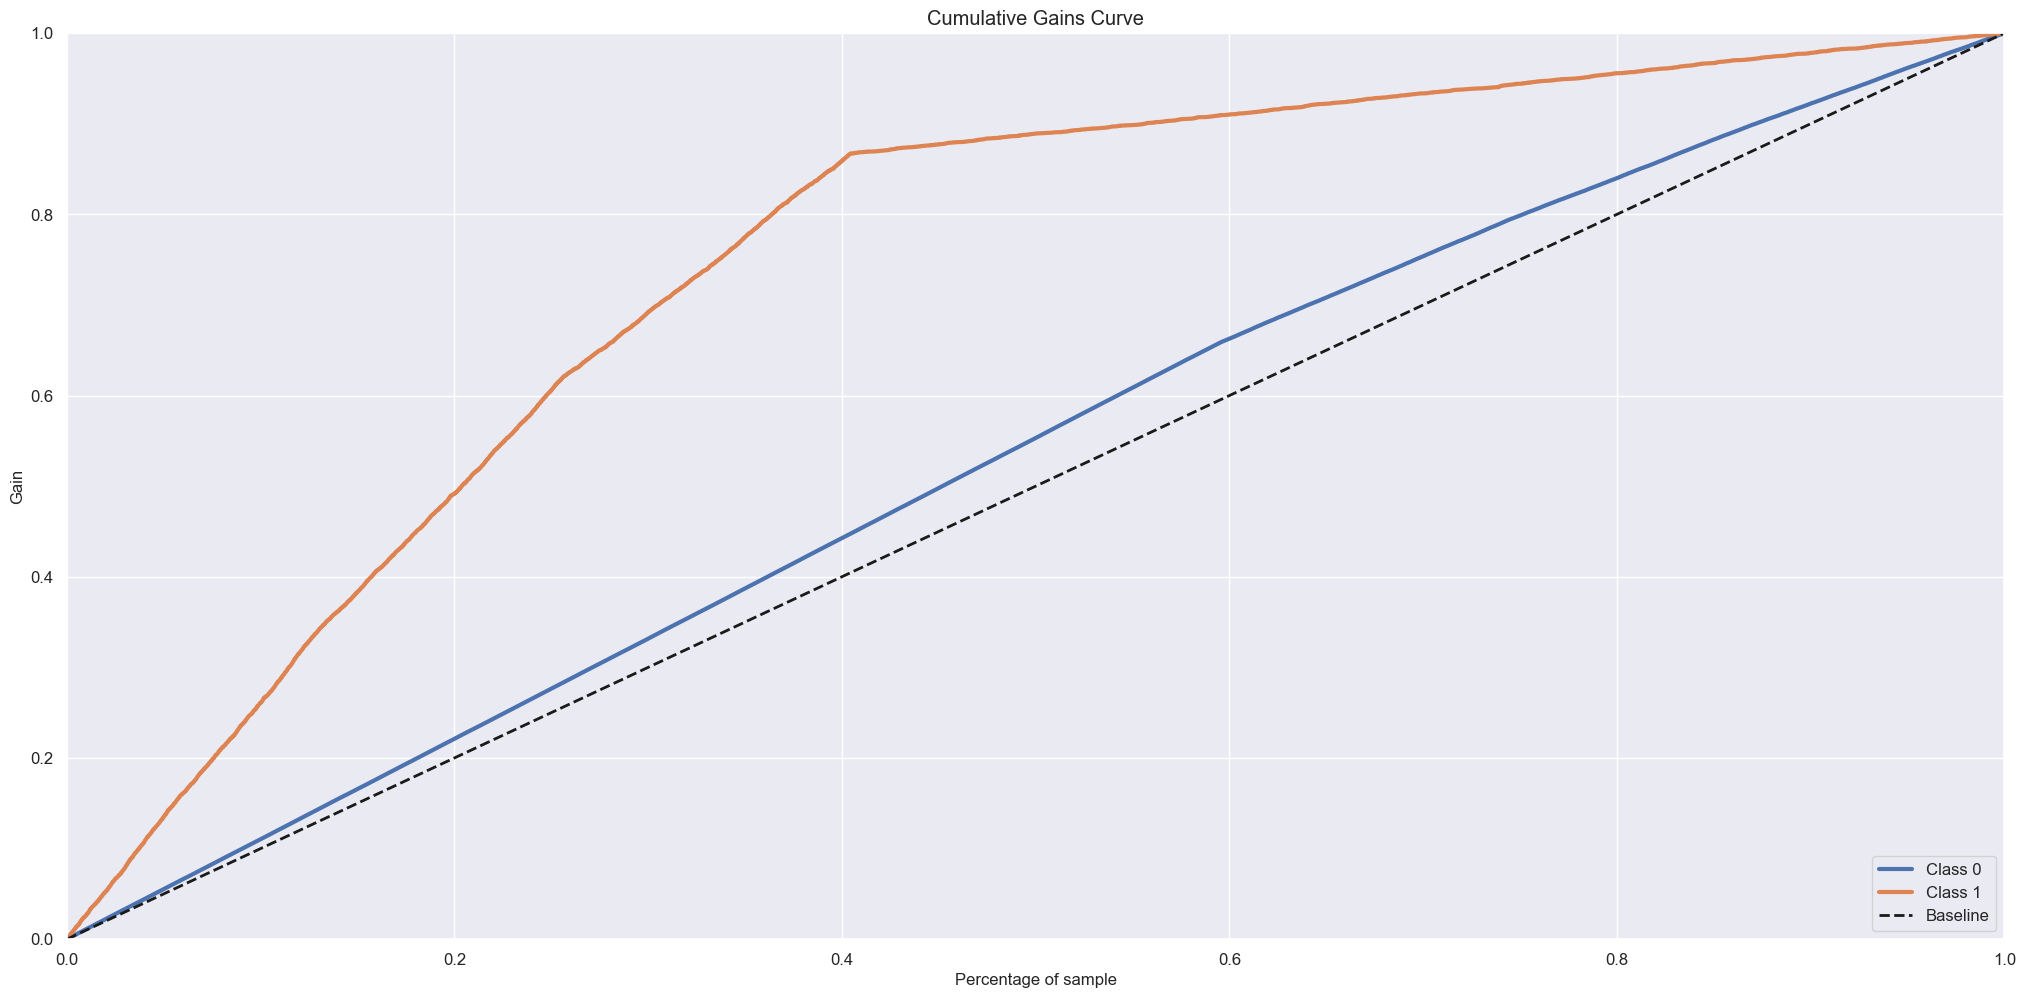

In [48]:
# Accumulative gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn);

### 7.1.1 K-Nearest Neighbors - Cross-Validation

In [49]:
# making cross validation
#cv_knn = runCrossValidation(knn_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_knn, open('../data/processed/cv_knn.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_knn.pkl','rb')
cv_knn = pickle.load(file)
file.close()

cv_knn

,mean,std
precision_at_k,0.204,0.001
recall_at_k,0.896,0.004


## 7.2 Logistic Regression

In [50]:
# model definition
lr_model = lm.LogisticRegression( random_state=42 ) 

# model training
lr_model.fit( x_train, y_train )

# model prediction
yhat_lr = lr_model.predict_proba( x_val )
yhatp_lr = lr_model.predict( x_val )


# ---------- Metrics ------------------
# Accuracy score
ba_lr = balanced_accuracy_score(y_val, yhatp_lr)

print(f'Accuracy from balanced score is: {ba_lr:.3f}')

Accuracy from balanced score is: 0.500


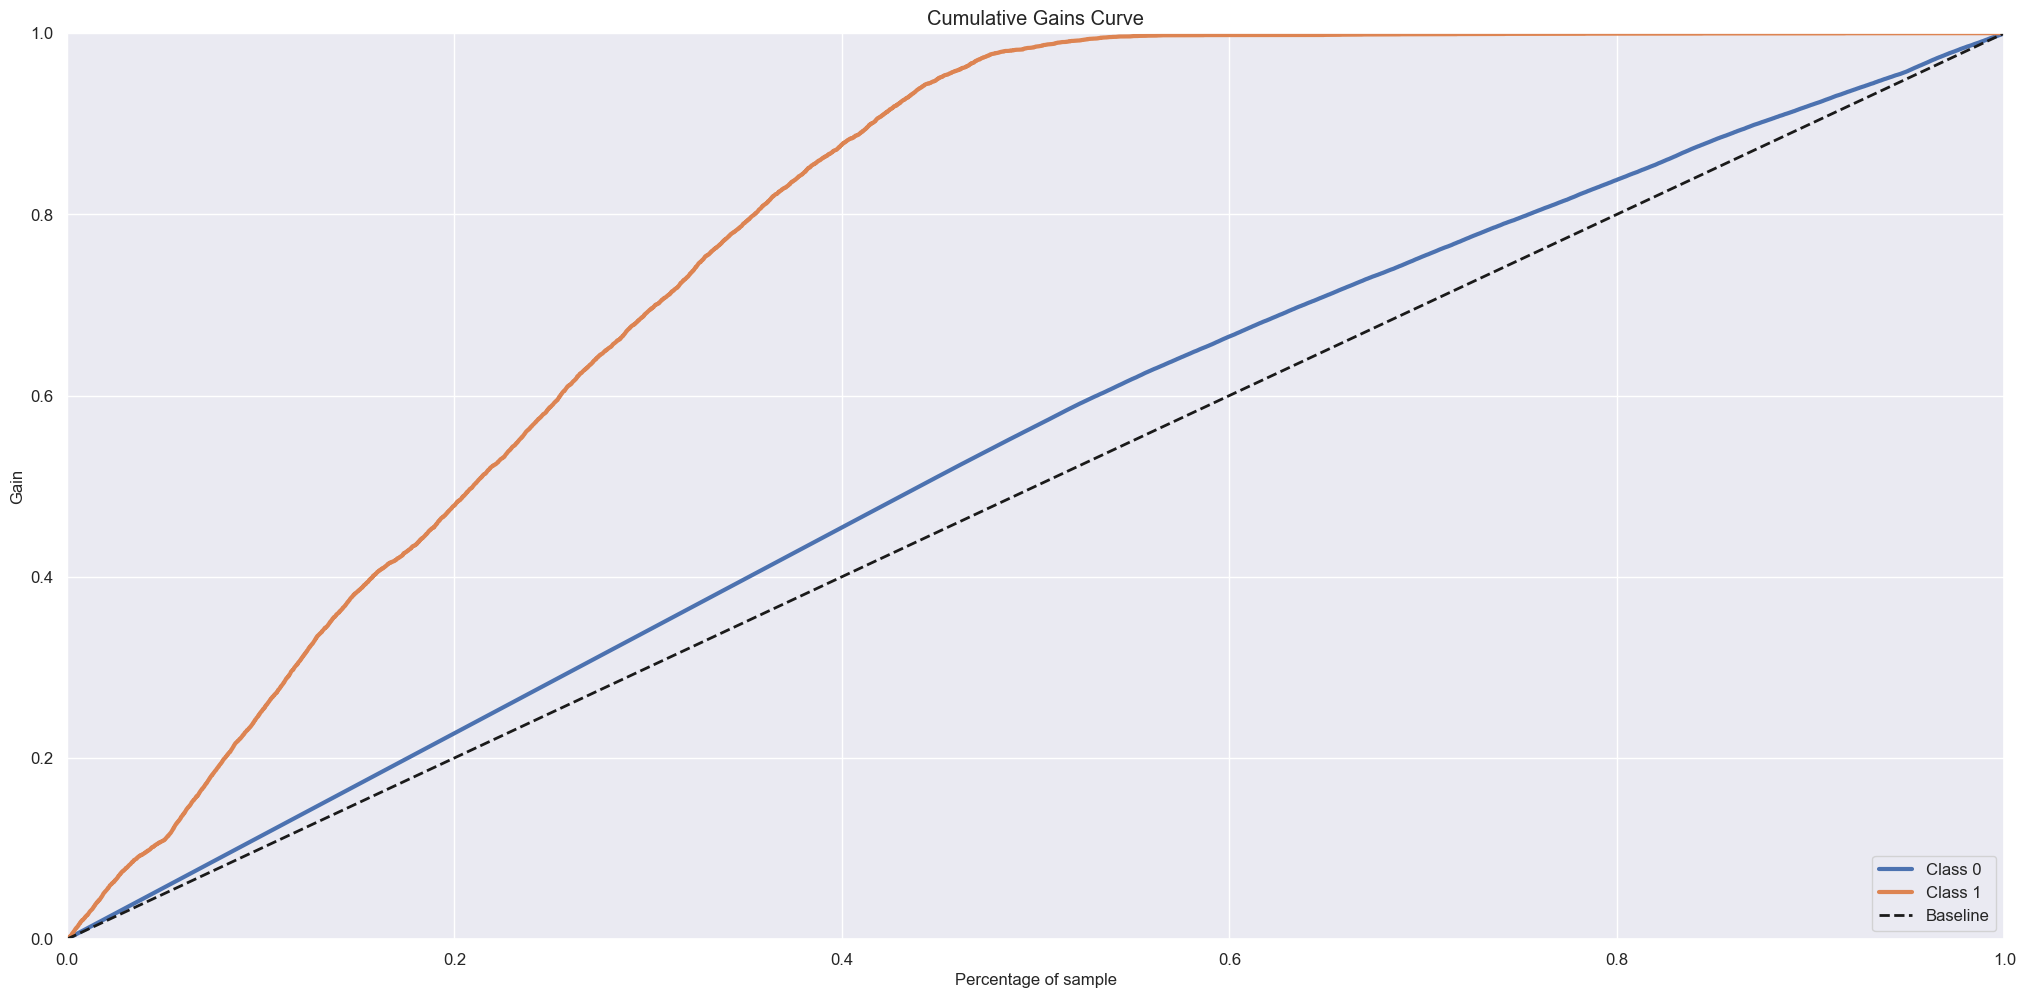

In [51]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr );

### 7.2.1 Logistic Regression - Cross-Validation

In [52]:
# making cross validation
#cv_lr = runCrossValidation(lr_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_lr, open('../data/processed/cv_lr.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_lr.pkl','rb')
cv_lr = pickle.load(file)
file.close()

cv_lr

,mean,std
precision_at_k,0.226,0.000
recall_at_k,0.996,0.001


## 7.3 Extra Trees

In [53]:
# model definition
#et_model = en.ExtraTreesClassifier(n_estimators=1000, n_jobs=-1, random_state=42) 

# model training
#et_model.fit( x_train, y_train )

# model prediction
#yhat_et = et_model.predict_proba( x_val )
#yhatp_et = et_model.predict( x_val )

# ---------- Metrics ------------------
# Accuracy score
#ba_et = balanced_accuracy_score(y_val, yhatp_et)

# Accumulative gain plot
#plot_et = skplt.metrics.plot_cumulative_gain( y_val, yhat_et);

# -------------- Saving and Loading Metrics -------------------
# saving results
#pickle.dump(ba_et, open('../data/interim/ba_et.pkl', 'wb'))
#pickle.dump(plot_et, open('../data/interim/plot_et.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_et.pkl','rb')
ba_et = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_et:.3f}')

Accuracy from balanced score is: 0.549


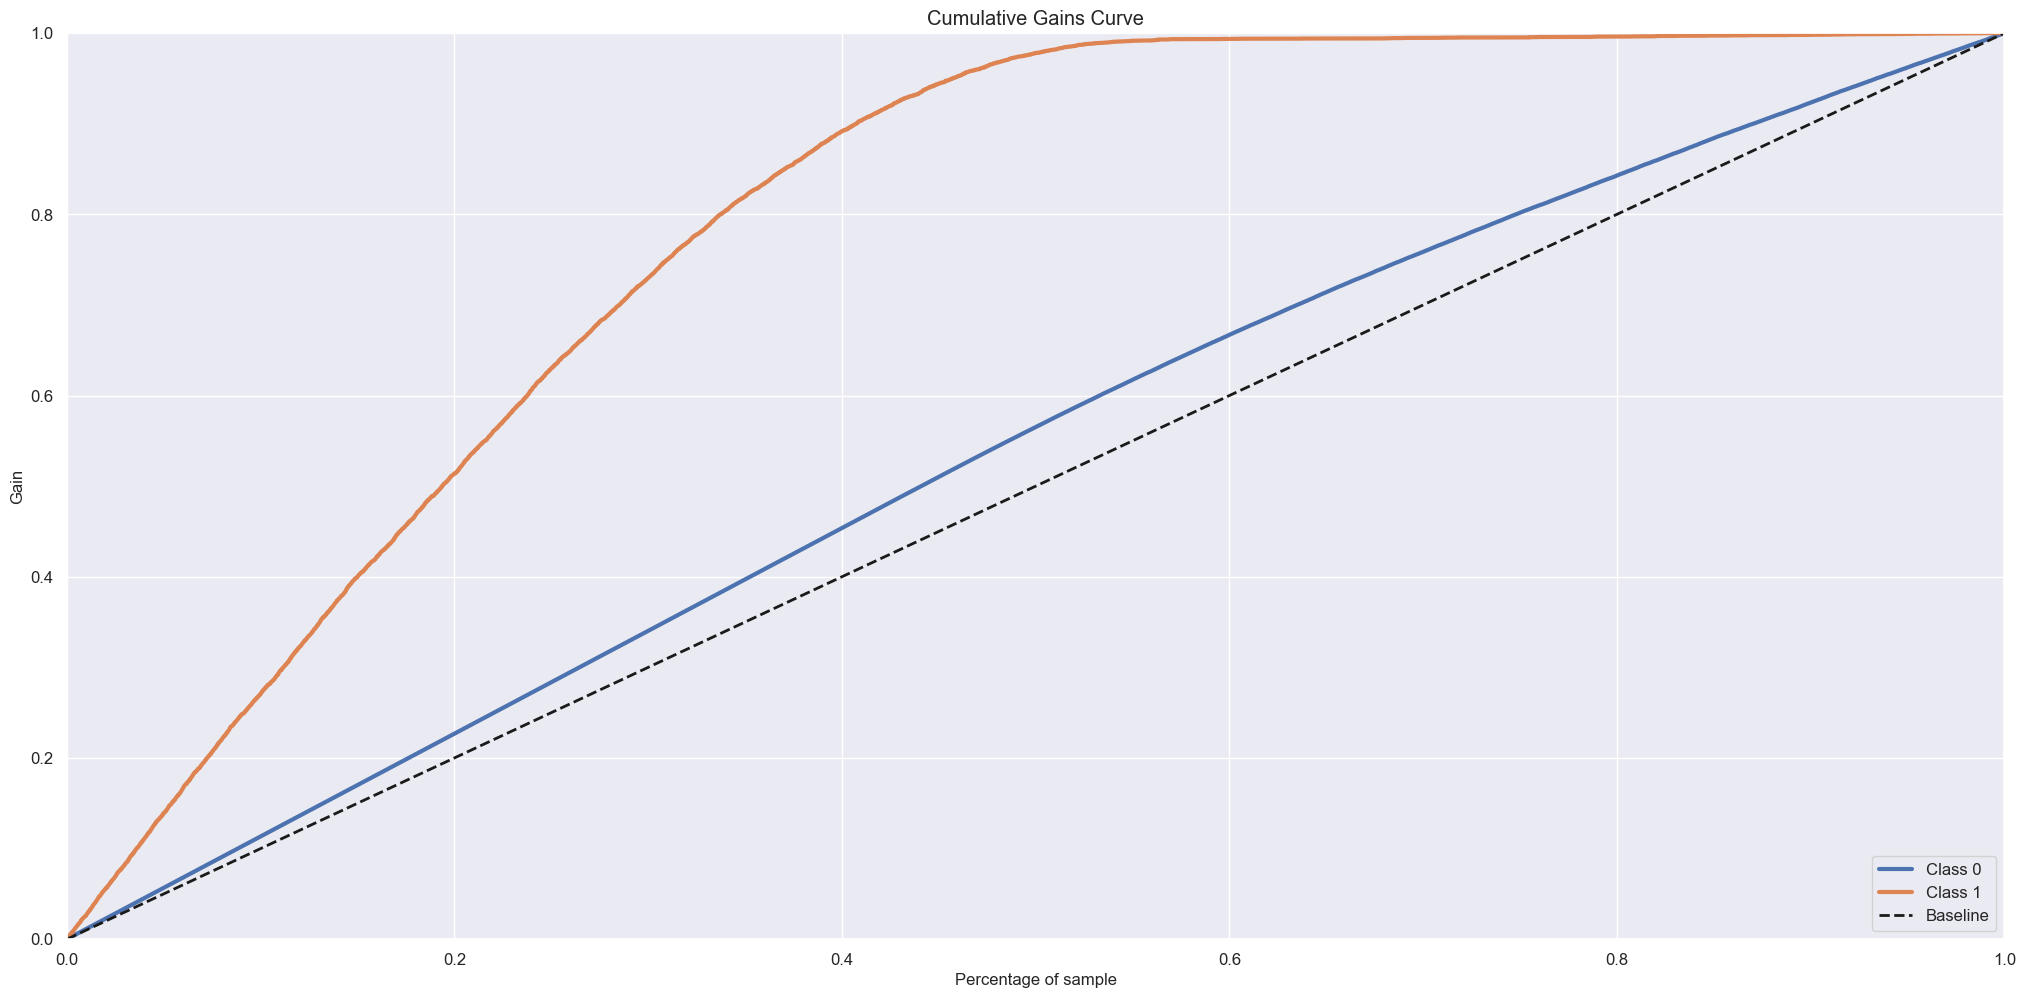

In [54]:
# loading results
file = open('../data/interim/plot_et.pkl','rb')
plot_et = pickle.load(file)
file.close()

# Accumulative Gain
plot_et;

### 7.3.1 Extra Trees - Cross-Validation

In [55]:
# making cross validation
#cv_et = runCrossValidation(et_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_et, open('../data/processed/cv_et.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_et.pkl','rb')
cv_et = pickle.load(file)
file.close()

cv_et

,mean,std
precision_at_k,0.225,0.000
recall_at_k,0.989,0.002


## 7.4 XGBoost

In [56]:
# model definition
#xgb_model = XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
#xgb_model.fit( x_train, y_train )

# model prediction
#yhat_xgb = xgb_model.predict_proba( x_val )
#yhatp_xgb = xgb_model.predict( x_val )

# ---------- Metrics ------------------
# Accuracy score
#ba_xgb = balanced_accuracy_score(y_val, yhatp_xgb)

# Accumulative gain plot
#plot_xbg = skplt.metrics.plot_cumulative_gain( y_val, yhat_xgb );


# -------------- Saving and Loading model -------------------
# saving results
#pickle.dump(ba_xgb, open('../data/interim/ba_xgb.pkl', 'wb'))
#pickle.dump(plot_xbg, open('../data/interim/plot_xbg.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_xgb.pkl','rb')
ba_xgb = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_xgb:.3f}')

Accuracy from balanced score is: 0.533


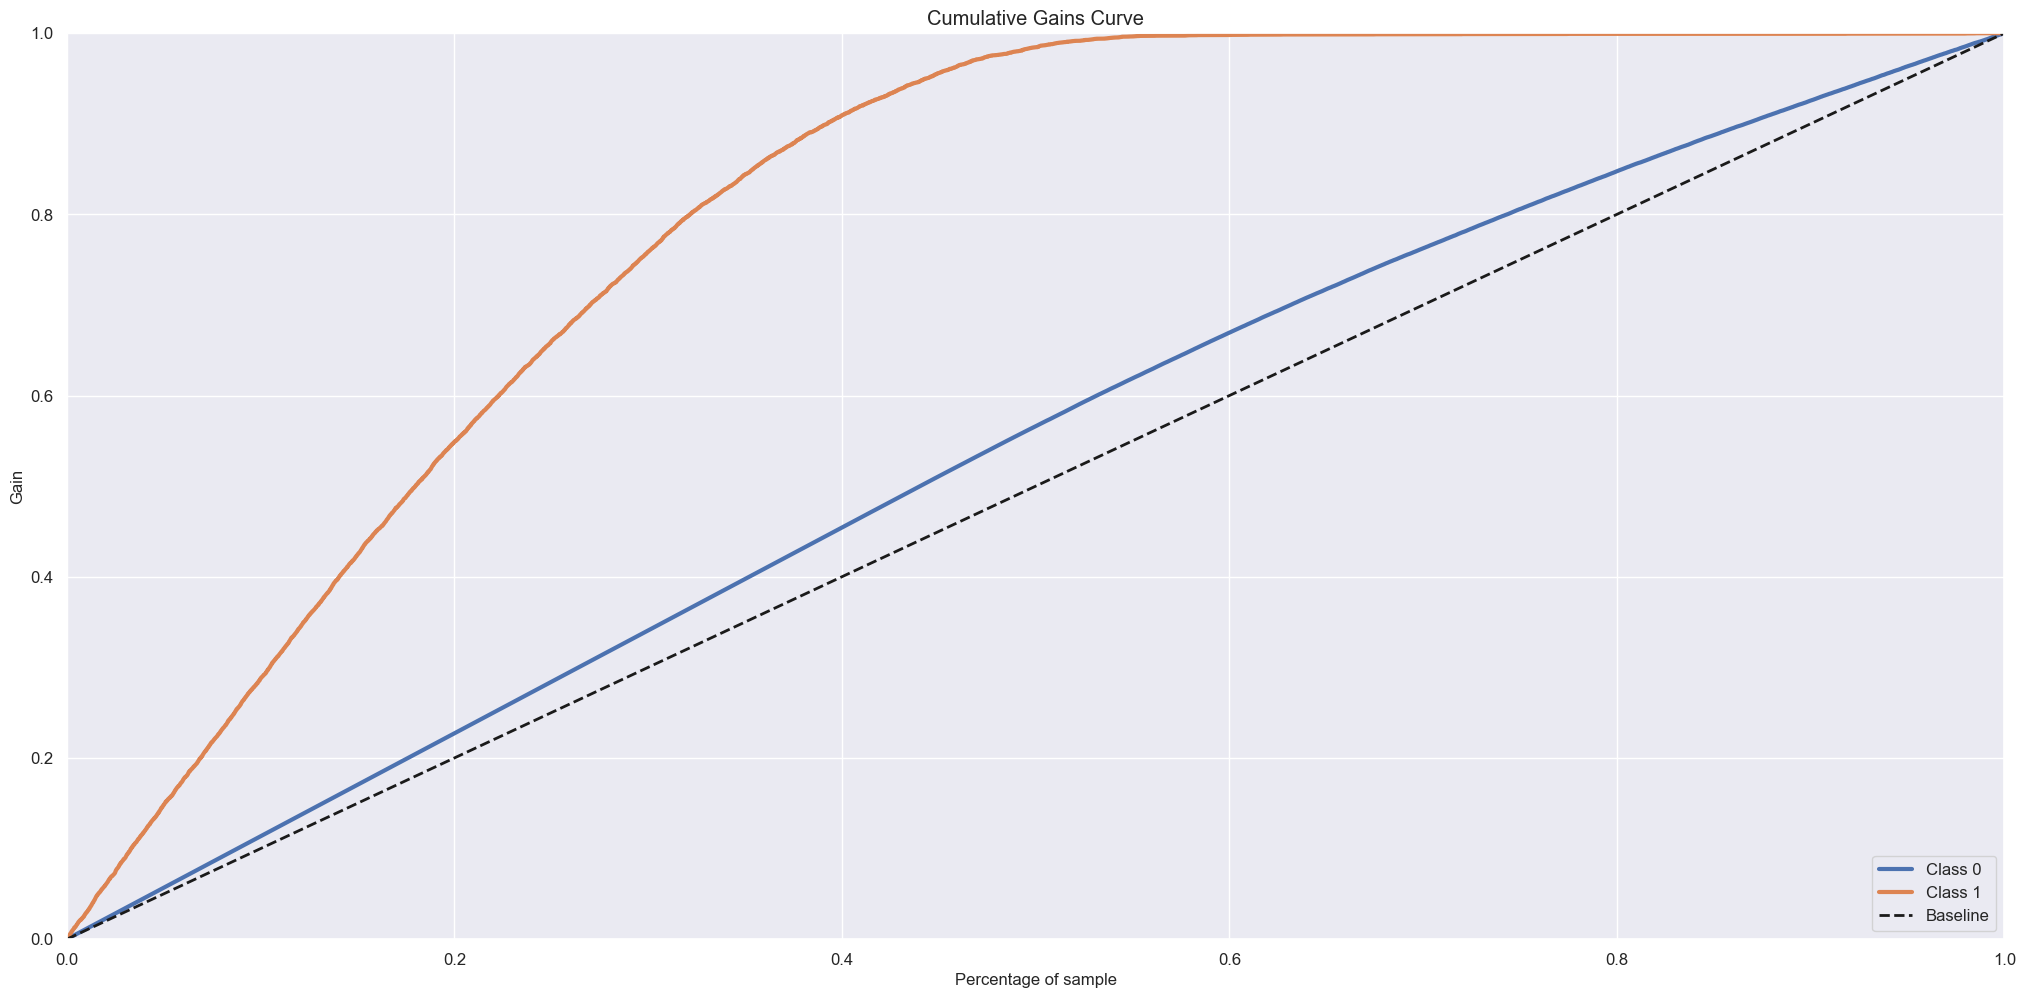

In [57]:
# loading results
file = open('../data/interim/plot_xbg.pkl','rb')
plot_xbg = pickle.load(file)
file.close()

# ---------- Metrics ------------------
# Accumulative Gain
plot_xbg;

### 7.4.1 XGBoost - Cross-Validation

In [58]:
# making cross validation
#cv_xgb = runCrossValidation(xgb_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k = 20000, verbose=True)

# saving results
#pickle.dump(cv_xgb, open('../data/processed/cv_xgb.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_xgb.pkl','rb')
cv_xgb = pickle.load(file)
file.close()

cv_xgb

,mean,std
precision_at_k,0.226,0.000
recall_at_k,0.995,0.001


## 7.5 LGBM

In [59]:
# model definition
lgbm_model = LGBMClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
lgbm_model.fit( x_train, y_train )

# model prediction
yhat_lgbm = lgbm_model.predict_proba( x_val )
yhatp_lgbm = lgbm_model.predict( x_val )


# ---------- Metrics ------------------
# Accuracy score
ba_lgbm = balanced_accuracy_score(y_val, yhatp_lgbm)

print(f'Accuracy from balanced score is: {ba_lgbm:.3f}')

Accuracy from balanced score is: 0.503


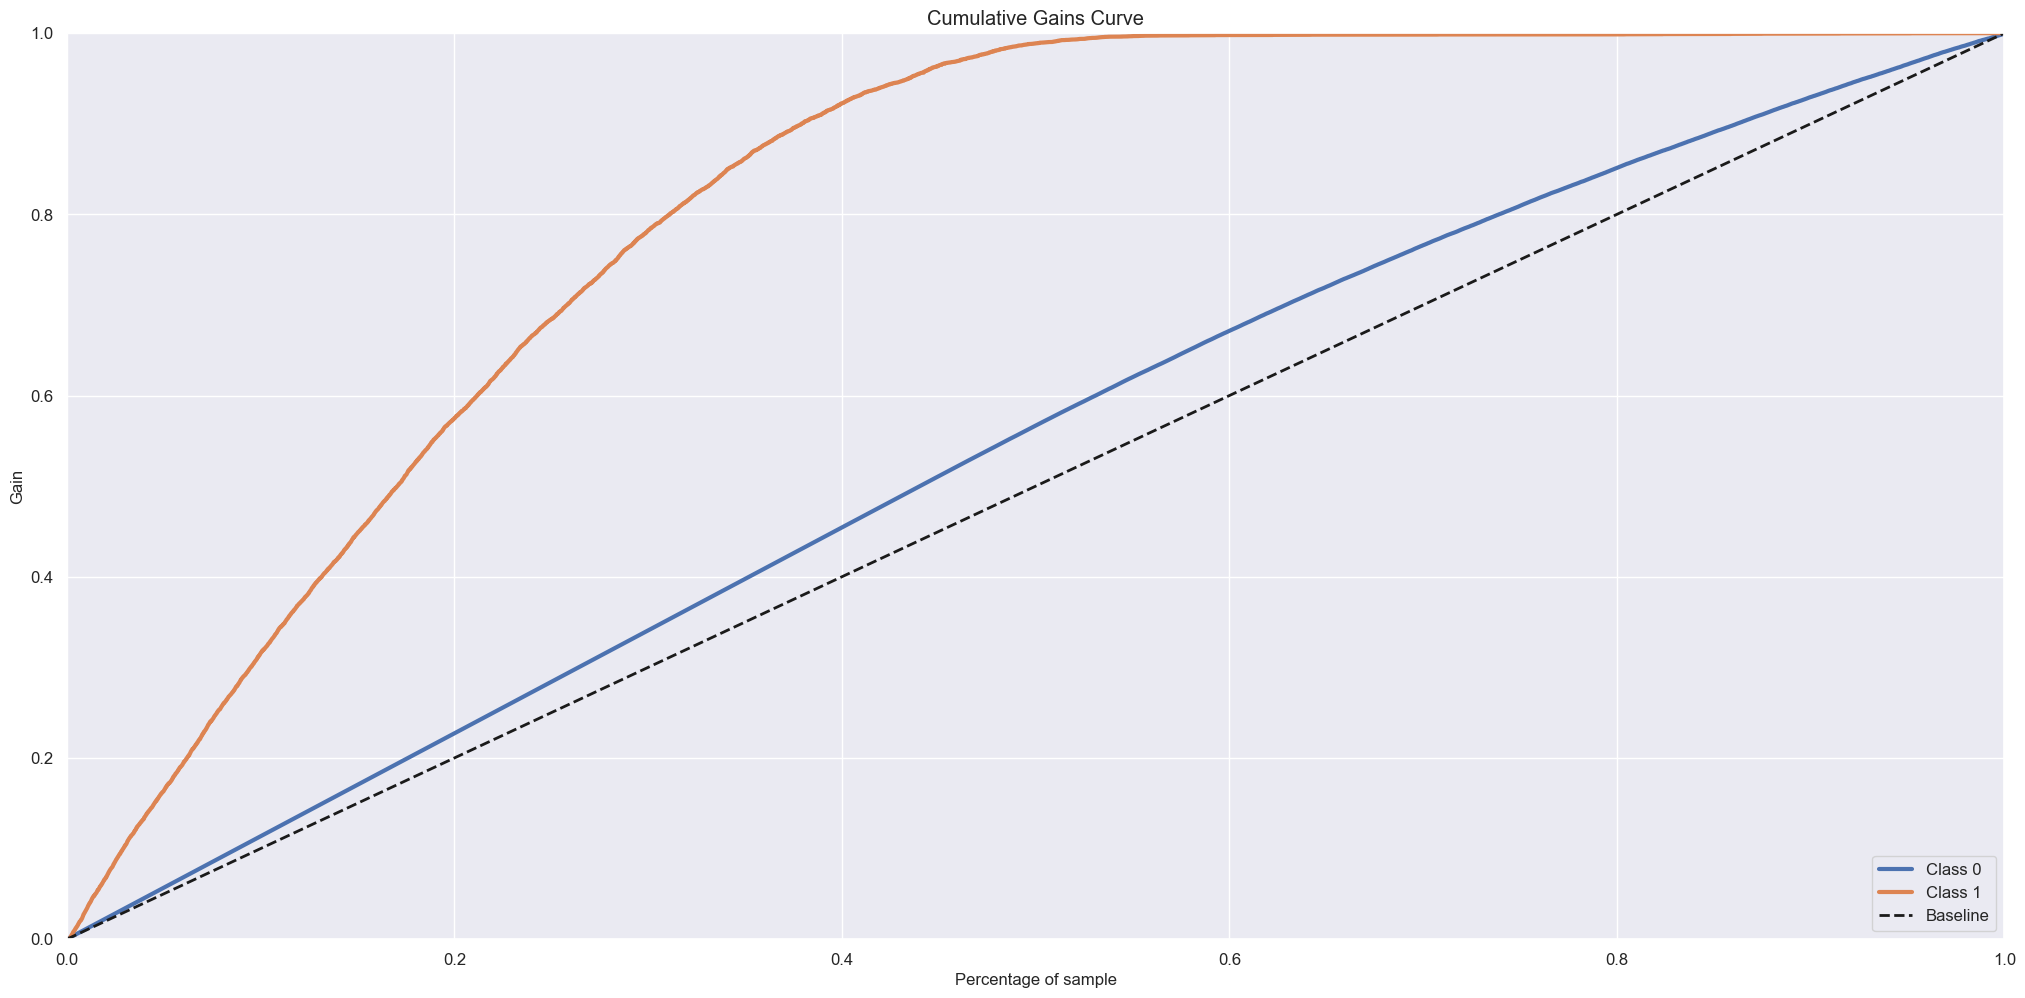

In [60]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lgbm );

### 7.5.1 LGBM - Cross-Validation

In [61]:
# making cross validation
#cv_lgbm = runCrossValidation(lgbm_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k=20000, verbose=True)

# saving results
#pickle.dump(cv_lgbm, open('../data/processed/cv_lgbm.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_lgbm.pkl','rb')
cv_lgbm = pickle.load(file)
file.close()

cv_lgbm

,mean,std
precision_at_k,0.226,0.000
recall_at_k,0.992,0.001


## 7.6 Balanced Random Forest Classifier

In [62]:
# model definition
#brf_model = ien.BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42, sampling_strategy=0.14)

# model training
#brf_model.fit( x_train, y_train )

# model prediction
#yhat_brf = brf_model.predict_proba( x_val )
#yhatp_brf = brf_model.predict( x_val )

# ---------- Metrics ------------------
# Accuracy score
#ba_brf = balanced_accuracy_score(y_val, yhatp_brf)

# Accumulative gain plot
#plot_brf = skplt.metrics.plot_cumulative_gain( y_val, yhat_brf )


# -------------- Saving and Loading model -------------------
# saving results
#pickle.dump(ba_brf, open('../data/interim/ba_brf.pkl', 'wb'))
#pickle.dump(plot_brf, open('../data/interim/plot_brf.pkl', 'wb'))

# loading results
file = open('../data/interim/ba_brf.pkl','rb')
ba_brf = pickle.load(file)
file.close()

# show metrics
print(f'Accuracy from balanced score is: {ba_brf:.3f}')

Accuracy from balanced score is: 0.546


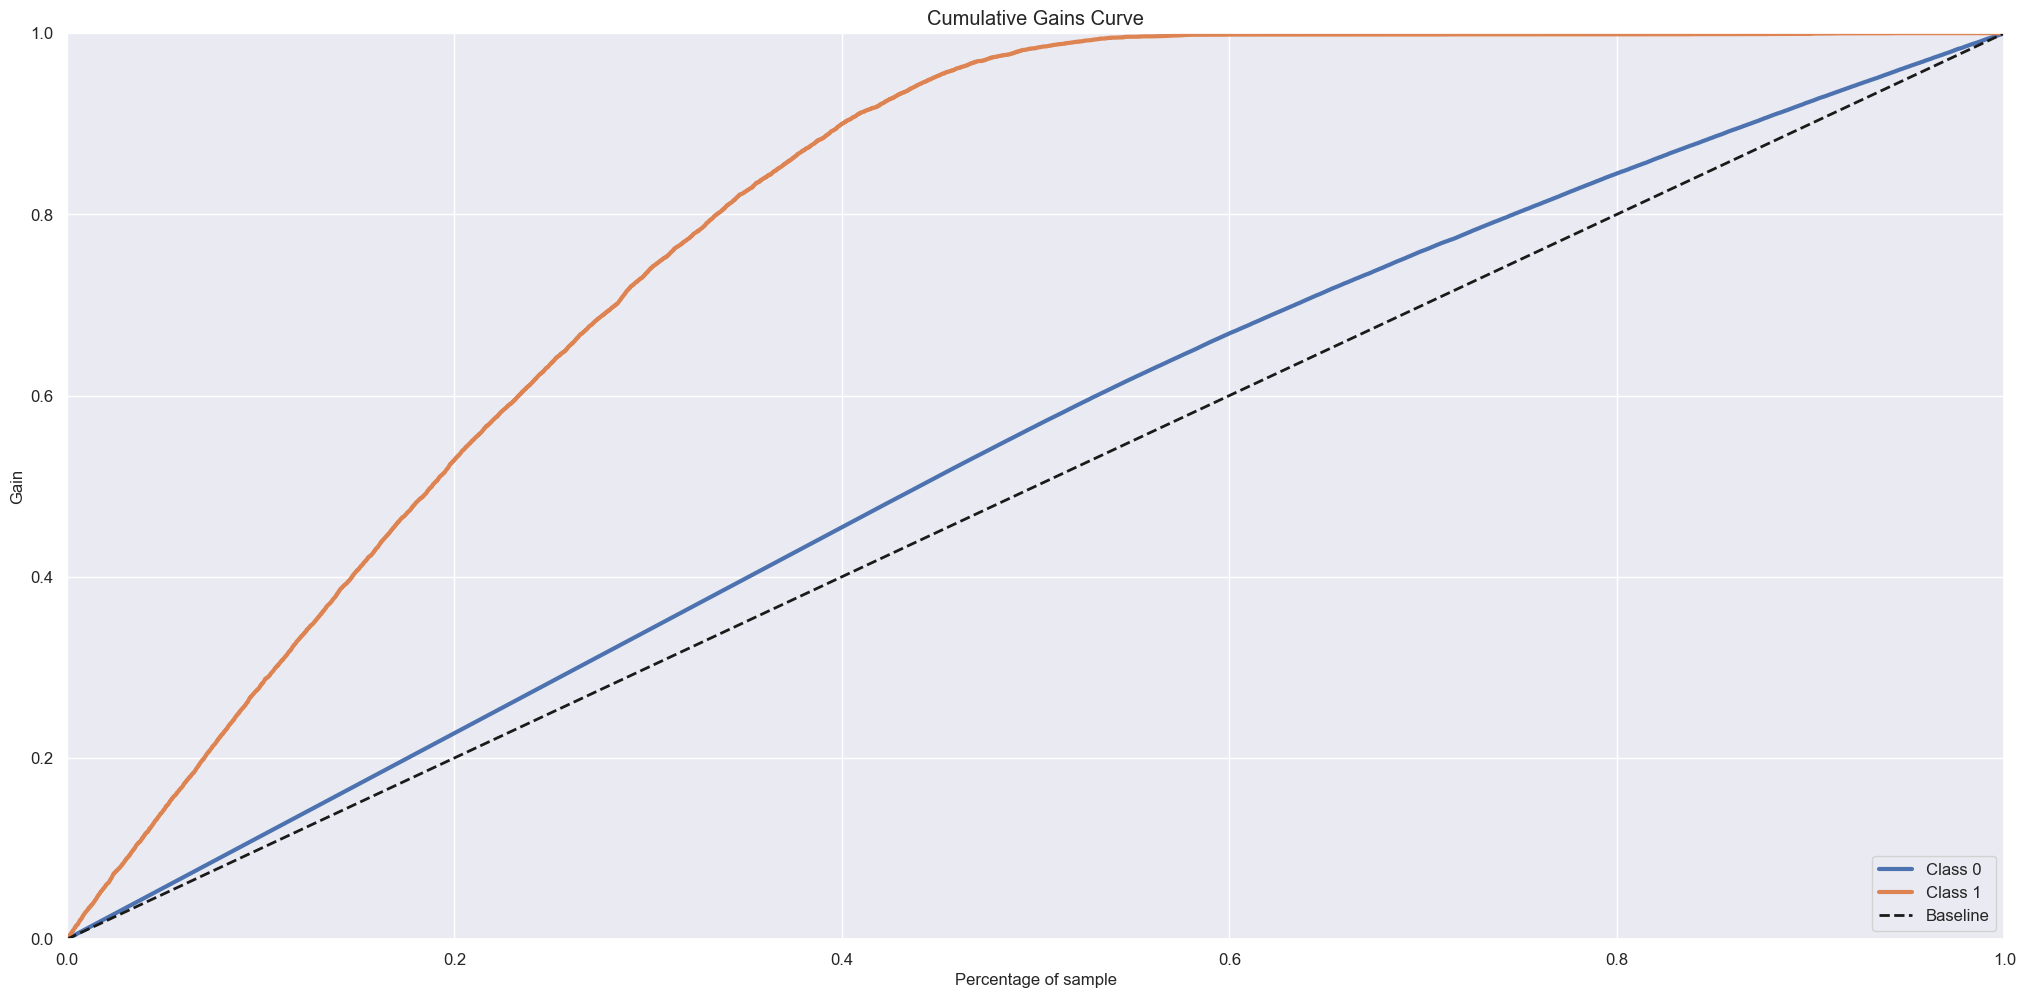

In [63]:
# loading results
file = open('../data/interim/plot_brf.pkl','rb')
table_brf = pickle.load(file)
file.close()

# ---------- Metrics ------------------
# Accumulative Gain
table_brf;

### 7.6.1 Balanced Random Forest - Cross-Validation

In [64]:
# making cross validation
#cv_brf = runCrossValidation(brf_model, x_train, x_val, y_train, y_val, n_splits=10, n_repeats=2, top_k=20000, verbose=True)

# saving results
#pickle.dump(cv_brf, open('../data/processed/cv_brf.pkl', 'wb'))

# loading results
file = open('../data/processed/cv_brf.pkl','rb')
cv_brf = pickle.load(file)
file.close()

cv_brf

,mean,std
precision_at_k,0.122,0.001
recall_at_k,0.536,0.005


## 7.6 Compare Model's Performance

### 7.6.1 Single Performance

In [65]:
#model_list = {'KNN_model' : yhat_knn, 'Logistic_Regression' : yhat_lr, 'Extra_Trees_Classifier' : yhat_et, 'XGBoost' : yhat_xgb, 'LGBM' : yhat_lgbm, 'Balanced_RF' : yhat_brf}
#results = pd.DataFrame(columns=['model_name', 'precision_at_K', 'recall_at_K'])

#for n, m in model_list.items():
    # copy data
#    df8 = x_validation.copy()
#    df8['response'] = y_validation.copy()

    # propensity score
#    df8['score'] = m[:, 1].tolist()

    # sort clients by propensity score
#    df8 = df8.sort_values( 'score', ascending=False )

    # compute precision and recall at 20.000 k
#    metrics, data = precision_recall_at_k(df8)

#    metricst = metrics
#    metricst = pd.DataFrame(metricst)
#    metricst = metricst.T
#    metricst['model_name'] = n
#    metricst.columns = ['precision_at_K', 'recall_at_K', 'model_name']
#    metricst = metricst[['model_name', 'precision_at_K', 'recall_at_K']]
#    results = pd.concat([metricst, results])

# sort results
#results.sort_values('precision_at_K', ascending=False, inplace=True)

# saving results
#pickle.dump(results, open('../data/processed/ml_result.pkl', 'wb'))

# loading results
file = open('../data/processed/ml_result.pkl','rb')
ml_result = pickle.load(file)
file.close()

ml_result

,model_name,precision_at_K,recall_at_K
0,LGBM,0.326,0.714
0,XGBoost,0.314,0.688
0,Balanced_RF,0.306,0.670
0,Extra_Trees_Classifier,0.301,0.659
0,KNN_model,0.291,0.637
0,Logistic_Regression,0.288,0.630


### 7.6.2 Real Performance - Cross Validation

In [66]:
#final_cv = pd.DataFrame()
#model_list = {'KNN_model' : cv_knn, 'Logistic_Regression' : cv_lr, 'Extra_Trees_Classifier' : cv_et, 'XGBoost' : cv_xgb, 'LGBM' : cv_lgbm}

#for n, m in model_list.items():
#    m[n] = m.apply(lambda x : (str(x['mean']))[:5] + '+/-' + (str(x['std']))[:5], axis=1)
#    m = m[[n]].T
#    m.reset_index(inplace=True)
#    m.columns = ['model_name', 'precision_at_k', 'recall_at_k']

#    final_cv = pd.concat([final_cv, m])

#final_cv.sort_values('precision_at_k', ascending=False, inplace=True)

# saving results
#pickle.dump(final_cv, open('../data/processed/ml_result_cv.pkl', 'wb'))

# loading results
file = open('../data/processed/ml_result_cv.pkl','rb')
ml_result_cv = pickle.load(file)
file.close()

ml_result_cv

,model_name,precision_at_k,recall_at_k
0,Logistic_Regression,0.226+/-0.000,0.996+/-0.000
0,XGBoost,0.226+/-0.000,0.994+/-0.001
0,LGBM,0.226+/-0.000,0.996+/-0.001
0,Extra_Trees_Classifier,0.224+/-0.000,0.988+/-0.001
0,KNN_model,0.203+/-0.001,0.896+/-0.004


# 8.0 Hyper Parameter Fine Tunning

## 8.1 Bayesian Search

In [67]:
# Search space for hyper parameters
#search_space = [Integer( 100, 1500, name = 'n_estimators'), 
#                Integer(1, 20, name = 'max_depth'), 
#                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),
#                Integer(2, 128, name = 'num_leaves'),
#                Integer(1, 100, name = 'min_child_samples'),
#                Real(0.05, 1.0, name = 'subsample'),
#                Real(0.15, 1.0, name = 'colsample_bytree')]

# model definition
#lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1)

# applying cross-validation into tunning
#@use_named_args(search_space)
#def model_eval( **params ):
	
#    lgbm_model.set_params(**params)
#    print(lgbm_model)
#    ft_result = runCrossValidation(lgbm_model, x_train, x_val, y_train, y_val, n_splits=5, n_repeats=1, top_k=20000, verbose=False)
#    return -ft_result['mean'][0]

# create checkpoints
#checkpoint_callback = CheckpointSaver('../models/lgbm_ft.pkl')

# return results and run bayesian optimize
#result = gp_minimize( model_eval, search_space, n_calls = 30, 
#                      n_initial_points = 10, verbose=True, n_jobs=-1, 
#                      random_state= 42, callback=[checkpoint_callback])
#result

In [68]:
# check best parameters

#result.x

## 8.2 Final Model

In [69]:
# best parameters
params = {'n_estimators' : 753,
            'max_depth' : 17,
            'learning_rate' : 0.02294,
            'num_leaves' : 59,
            'min_child_samples' : 2,
            'subsample' : 0.9450,
            'colsample_bytree' : 0.6287}


# LGBM Model
lgbm_model = LGBMClassifier(n_jobs=-1, random_state=42, subsample_freq=1)
lgbm_model.set_params(**params)
lgbm_model.fit(x_train, y_train)

# results of train dataset
y_pred = lgbm_model.predict_proba( x_val )

In [70]:
# ------- check result--------

df8 = x_validation.copy()
df8['response'] = y_validation.copy()

# propensity score
df8['score'] = y_pred[:, 1].tolist()

# sort clients by propensity score
df8 = df8.sort_values( 'score', ascending=False )

# compute precision and recall at 20.000 k
metrics, data = precision_recall_at_k(df8)

# organize results
metrics = pd.DataFrame(metrics)
metrics = metrics.T
metrics['model_name'] = 'LGBM_Model'
metrics.columns = ['precision_at_K', 'recall_at_K', 'model_name']
metrics = metrics[['model_name', 'precision_at_K', 'recall_at_K']]
metrics


,model_name,precision_at_K,recall_at_K
0,LGBM_Model,0.327,0.731


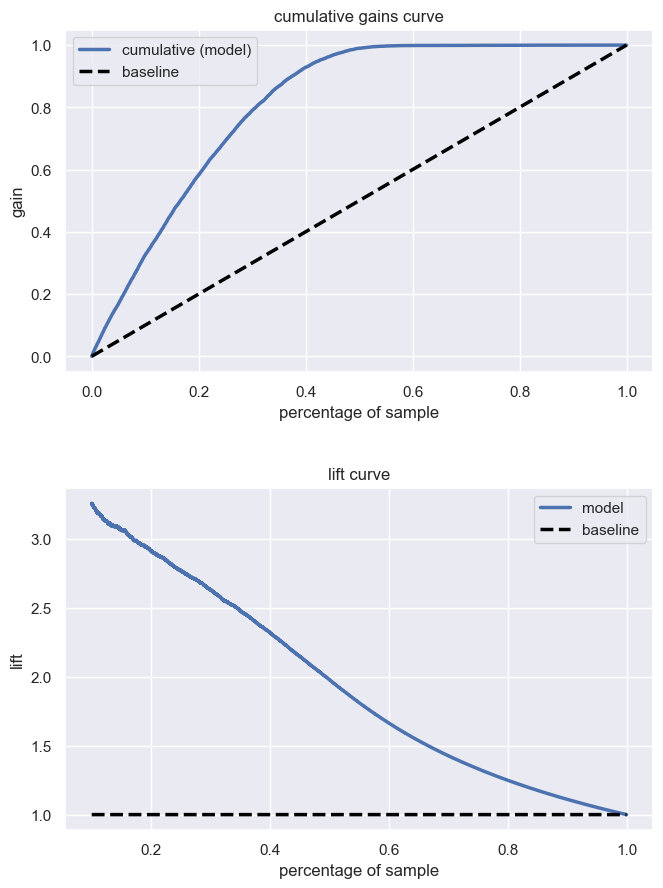

In [71]:
data = gain_lift_curve(y_pred, y_val)

# 9.0 Tradução e interpretação do erro

In [72]:
df8

,id,gender,age,region_code,policy_sales_channel,vehicle_damage,previously_insured,annual_premium,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response,score
316021,239129,0.103,0.015,0.073,0.058,0,0,-0.369,0.567,1,0,0,0,1.000
40232,320935,0.103,0.062,0.098,0.357,0,1,0.279,0.509,1,0,0,0,1.000
366155,261868,0.139,0.015,0.073,0.058,0,1,-0.371,0.156,1,0,0,0,0.990
189620,371397,0.139,0.015,0.073,0.058,0,1,-0.370,0.882,1,0,0,0,0.989
302881,133838,0.139,0.062,0.071,0.357,0,1,-0.371,0.401,1,0,0,0,0.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276088,301073,0.103,0.415,0.122,0.002,0,1,0.279,0.256,0,1,0,0,0.000
288108,15054,0.139,0.308,0.122,0.357,0,1,0.279,0.557,0,1,0,0,0.000
22325,178105,0.103,0.846,0.122,0.205,0,1,0.282,0.460,0,1,0,0,0.000
99739,33139,0.103,0.354,0.094,0.194,0,1,0.209,0.336,0,1,0,0,0.000


In [73]:
df9 = df8.copy()

## 9.1 Bussiness Performance

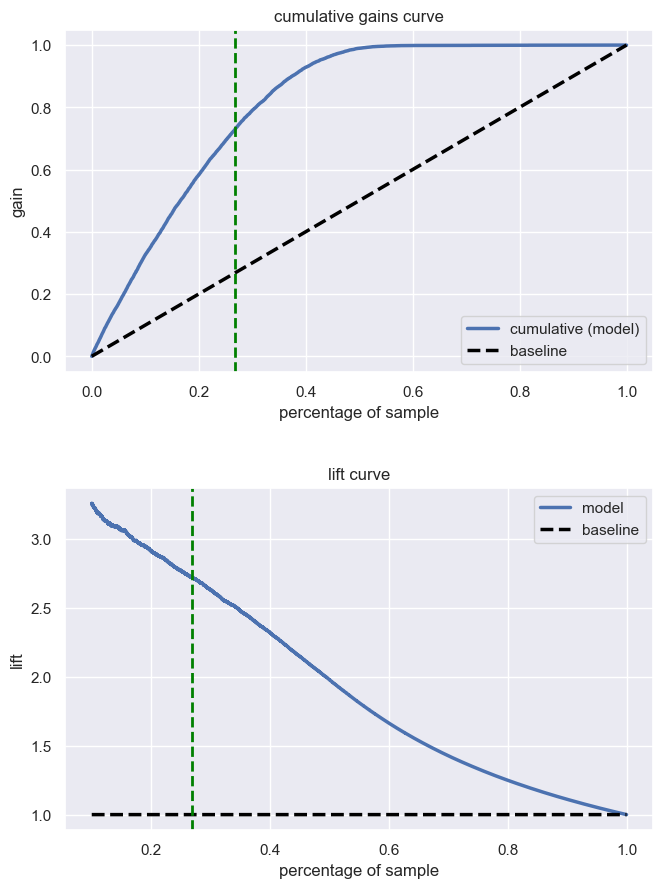

We have 74487 new customers, of which 8959 are interested in vehicle insurance. (12.03% of total new customers)
The average ticket for an annual car insurance from 2021 is: Rs 4.273,83.

Assuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be 
the same as the average of 2021 is, we can estimate as invoicing scenarios:

_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________
By random list:
 - The sales team contacts 27% of those interested in car insurance: 2406 customers (see Gain: intersection black x green line).
  ==>  Estimated revenue: 2450 * 4.273,83 = $104.71M per year.

By sorted list (model):
 - The sales team contacts 73% of those interested in car insurance: 6546 customers (see Gain: intersection blue x green line).
  ==> Estimated revenue: 6546 * 4.273,83 = $2.86B per year.

RESULT: The model is 2.73 times

In [74]:
# traçar com 20k dos interessados
percent_at_20k = 20000 / len(df9)
recall_at_20k, table_20k = precision_recall_at_k(df9, k=20000)
curves_at_20k = gain_lift_curve(y_pred, y_validation, axvline=percent_at_20k)

#Scenario with 20000 phone calls

print (f"We have {df9.shape[0]} new customers, of which {round(df9.loc[df9['response'] == 1].shape[0])} are interested in vehicle insurance. ({round(df9.loc[df9['response'] == 1].shape[0] / df9.shape[0] *100 ,2) }% of total new customers)")

print (f"The average ticket for an annual car insurance from 2021 is: Rs 4.273,83.")
print (f"\nAssuming that all customers interested in vehicle insurance will sign the contract, and that the average value of vehicle insurance will be \
\nthe same as the average of 2021 is, we can estimate as invoicing scenarios:")

print (f"\n_______________________________ SCENARIO WITH 20000 PHONE CALLS _____________________________________________________________________________")
print (f"By random list:")
print (f" - The sales team contacts {round(20000 / df9.shape[0]*100 )}% of those interested in car insurance: {round( (20000 / df9.shape[0]*100 ) / 100 * (round(df9.loc[df9['response'] == 1].shape[0])) )} customers (see Gain: intersection black x green line).\n  ==>  Estimated revenue: 2450 * 4.273,83 = ${nm.numerize(104708835)} per year.")       

print (f"\nBy sorted list (model):")
print (f" - The sales team contacts {round(recall_at_20k[1]*100)}% of those interested in car insurance: {round( recall_at_20k[1]*100  / 100 * (df9.loc[df9['response'] == 1].shape[0]) )} customers (see Gain: intersection blue x green line).\n  ==> Estimated revenue: {round( recall_at_20k[1]*100  / 100 * (df9.loc[df9['response'] == 1].shape[0]) )} * 4.273,83 = ${nm.numerize(2857482738)} per year.")

print (f"\nRESULT: The model is {round(30087000 / 11025000 ,2)} times better than the random list (see Lift: intersection blue x green line). \nSo, the estimated revenue is {round(2857482738 / 104708835 ,2)} times higher than the random list: ${nm.numerize(2857482738 - 104708835)}.")

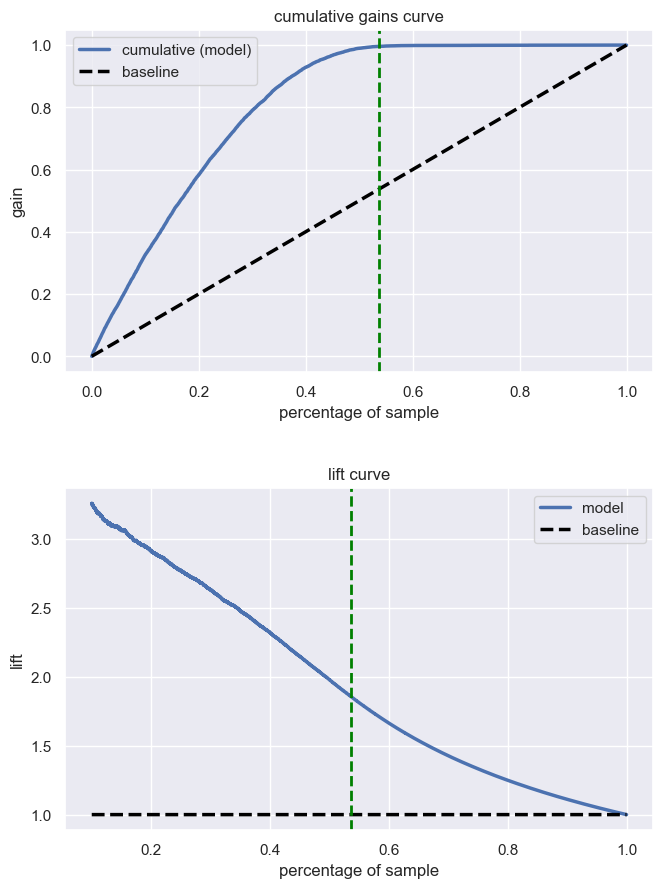

In [75]:
# traçar com 40k dos interessados
percent_at_40k = 40000 / len(df9)
curves_at_40k = gain_lift_curve(y_pred, y_validation, axvline=percent_at_40k)

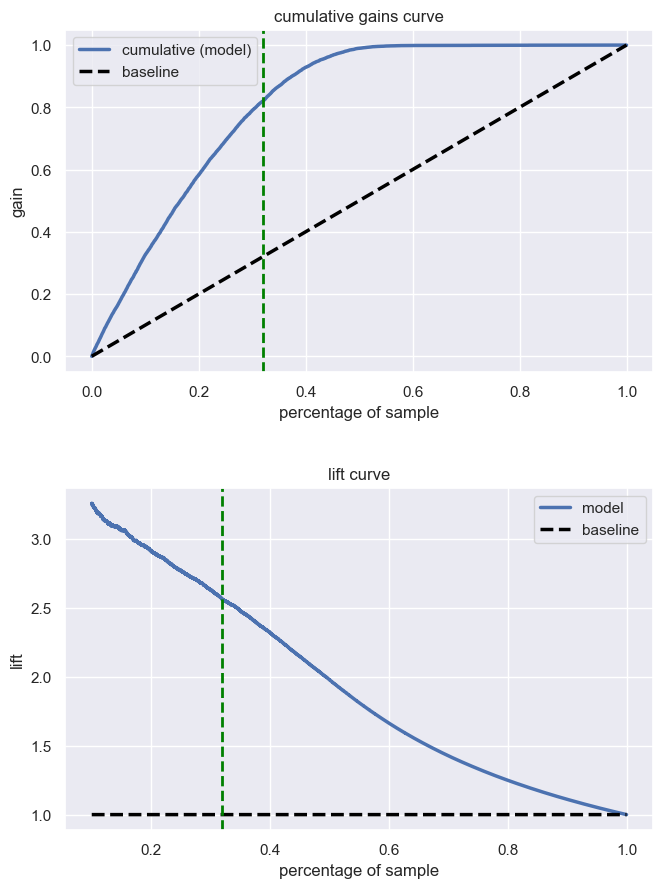

In [76]:
# traçar com 80% dos interessados
percent_at_80k = 23800 / len(df9)
curves_at_80k = gain_lift_curve(y_pred, y_validation, axvline=percent_at_80k)

## 9.2 Total Performance

## 9.3 Machine Learning Performance

In [77]:
print(percent_at_20k)
print(recall_at_20k[1])

0.26850322875132576
0.7306619042303829


# 10.0 Deploy model to production